In [2]:
import os
import shutil
import random

def split_data(source_dir, train_dir, val_dir, test_dir, train_split=0.8, val_split=0.1, test_split=0.1):
    assert train_split + val_split + test_split == 1, "Splits must sum to 1"
    
    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Iterate through each class folder
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Create class directories in train, val, and test directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Get list of all videos (subfolders) in the class directory
        videos = [d for d in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, d))]
        random.shuffle(videos)

        # Split videos into train, val, and test sets
        train_end = int(len(videos) * train_split)
        val_end = train_end + int(len(videos) * val_split)

        train_videos = videos[:train_end]
        val_videos = videos[train_end:val_end]
        test_videos = videos[val_end:]

        # Copy videos to their respective directories
        for video in train_videos:
            shutil.copytree(os.path.join(class_dir, video), os.path.join(train_dir, class_name, video))
        for video in val_videos:
            shutil.copytree(os.path.join(class_dir, video), os.path.join(val_dir, class_name, video))
        for video in test_videos:
            shutil.copytree(os.path.join(class_dir, video), os.path.join(test_dir, class_name, video))

if __name__ == "__main__":
    source_directory = "E:\\Projects\\Unfinished\\Sign Language\\Dataset Frames"
    train_directory = "E:\\Projects\\Unfinished\\Sign Language\\Dataset Organised\\train_directory"
    val_directory = "E:\\Projects\\Unfinished\\Sign Language\\Dataset Organised\\val_directory"
    test_directory = "E:\\Projects\\Unfinished\\Sign Language\\Dataset Organised\\test_directory"

    split_data(source_directory, train_directory, val_directory, test_directory)


In [4]:
import os
import random
from PIL import Image
from torchvision import transforms
import logging

# Set up logging
#logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Define custom transformation class
class VideoTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, video_frames):
        seed = random.randint(0, 2**32)
        transformed_frames = []
        for frame in video_frames:
            random.seed(seed)
            transformed_frame = self.transform(frame)
            transformed_frames.append(transformed_frame)
        return transformed_frames

# Define the augmentation pipeline
augmentation_pipeline = VideoTransform(transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
]))

# Function to load frames from a video directory
def load_video_frames(video_dir):
    logging.debug(f"Loading frames from {video_dir}")
    frames = []
    for frame_name in sorted(os.listdir(video_dir)):
        if frame_name.endswith('.jpg') or frame_name.endswith('.png'):
            frame_path = os.path.join(video_dir, frame_name)
            frame = Image.open(frame_path)
            frames.append(frame)
    logging.debug(f"Loaded {len(frames)} frames from {video_dir}")
    return frames

# Function to save augmented frames
def save_augmented_frames(augmented_frames, save_dir):
    logging.debug(f"Saving {len(augmented_frames)} frames to {save_dir}")
    os.makedirs(save_dir, exist_ok=True)
    for i, frame in enumerate(augmented_frames):
        save_path = os.path.join(save_dir, f"frame_{i:04d}.jpg")
        frame.save(save_path)
    logging.debug(f"Saved frames to {save_dir}")

# Function to process a single video
def process_video(video_info, augmentation_pipeline):
    source_video_dir, dest_video_dir = video_info
    logging.info(f"Processing video: {source_video_dir}")

    frames = load_video_frames(source_video_dir)
    if not frames:
        logging.warning(f"No frames found in {source_video_dir}")
        return

    augmented_frames = augmentation_pipeline(frames)
    save_augmented_frames(augmented_frames, dest_video_dir)

    logging.info(f"Finished processing video: {source_video_dir}")

# Function to gather video paths for processing
def gather_video_paths(source_dir, dest_dir):
    video_paths = []
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        for video_name in os.listdir(class_dir):
            video_dir = os.path.join(class_dir, video_name)
            if not os.path.isdir(video_dir):
                continue

            dest_class_dir = os.path.join(dest_dir, class_name)
            dest_video_dir = os.path.join(dest_class_dir, video_name)
            video_paths.append((video_dir, dest_video_dir))
    logging.debug(f"Gathered {len(video_paths)} video paths")
    return video_paths

if __name__ == "__main__":
    base_directory = "E:\\Projects\\Unfinished\\Sign Language\\Dataset Organised"
    augmented_base_directory = "E:\\Projects\\Unfinished\\Sign Language\\Dataset Augmented"
    subsets = ['train_directory', 'val_directory', 'test_directory']

    for subset in subsets:
        source_directory = os.path.join(base_directory, subset)
        augmented_directory = os.path.join(augmented_base_directory, subset)

        # Gather all video paths
        video_paths = gather_video_paths(source_directory, augmented_directory)

        # Process each video sequentially
        for video_info in video_paths:
            process_video(video_info, augmentation_pipeline)

    logging.info("Data augmentation completed")


2024-06-21 01:33:02,116 - INFO - Processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (10)


2024-06-21 01:33:13,181 - INFO - Finished processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (10)
2024-06-21 01:33:13,223 - INFO - Processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (11)
2024-06-21 01:33:23,847 - INFO - Finished processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (11)
2024-06-21 01:33:23,872 - INFO - Processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (12)
2024-06-21 01:33:32,058 - INFO - Finished processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (12)
2024-06-21 01:33:32,085 - INFO - Processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (13)
2024-06-21 01:33:42,506 - INFO - Finished processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (13)
2024-06-21 01:33:42

Feature Extractor!

In [5]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import logging

# Set up logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the feature extraction model
class CNNFeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(CNNFeatureExtractor, self).__init__()
        self.base_model = base_model
        self.base_model.fc = nn.Identity()  # Remove the final classification layer

    def forward(self, x):
        with torch.no_grad():
            features = self.base_model(x)
        return features

class TemporalFeatureExtractor(nn.Module):
    def __init__(self, cnn, feature_dim, rnn_hidden_size, rnn_num_layers):
        super(TemporalFeatureExtractor, self).__init__()
        self.cnn = cnn
        self.rnn = nn.LSTM(input_size=feature_dim,
                           hidden_size=rnn_hidden_size,
                           num_layers=rnn_num_layers,
                           batch_first=True)
    
    def forward(self, x):
        batch_size, num_frames, C, H, W = x.size()
        cnn_features = []
        for i in range(num_frames):
            frame_features = self.cnn(x[:, i, :, :, :])
            cnn_features.append(frame_features)
        cnn_features = torch.stack(cnn_features, dim=1)
        temporal_features, _ = self.rnn(cnn_features)
        return temporal_features

# Function to load frames from a video directory
def load_video_frames(video_dir, transform):
    frames = []
    for frame_name in sorted(os.listdir(video_dir)):
        if frame_name.endswith('.jpg') or frame_name.endswith('.png'):
            frame_path = os.path.join(video_dir, frame_name)
            frame = Image.open(frame_path).convert('RGB')
            frame = transform(frame)
            frames.append(frame)
    frames = torch.stack(frames)
    return frames

# Function to gather video paths for processing
def gather_video_paths(source_dir):
    video_paths = []
    for subset in ['train_directory', 'test_directory', 'val_directory']:  # Use the correct names as shown in your structure
        subset_dir = os.path.join(source_dir, subset)
        if not os.path.isdir(subset_dir):
            continue

        for class_name in os.listdir(subset_dir):
            class_dir = os.path.join(subset_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            for video_name in os.listdir(class_dir):
                video_dir = os.path.join(class_dir, video_name)
                if not os.path.isdir(video_dir):
                    continue

                video_paths.append((subset, class_name, video_name, video_dir))
    return video_paths

# Parameters
rnn_hidden_size = 512
rnn_num_layers = 2

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load pre-trained CNN model
cnn_model = models.resnet50(pretrained=True)
feature_dim = cnn_model.fc.in_features  # Store the feature dimension before replacing the fc layer
cnn_extractor = CNNFeatureExtractor(cnn_model)

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_extractor.to(device)
temporal_extractor = TemporalFeatureExtractor(cnn_extractor, feature_dim, rnn_hidden_size, rnn_num_layers)
temporal_extractor.to(device)
temporal_extractor.eval()

# Directories
original_data_directory = "E:\\Projects\\Unfinished\\Sign Language\\Dataset Organised"
augmented_data_directory = "E:\\Projects\\Unfinished\\Sign Language\\Dataset Augmented"
output_directory = "E:\\Projects\\Unfinished\\Sign Language\\Extracted Features"

os.makedirs(output_directory, exist_ok=True)

# Process both original and augmented datasets
data_sources = [
    ("original", original_data_directory),
    ("augmented", augmented_data_directory)
]

for source_name, source_directory in data_sources:
    video_paths = gather_video_paths(source_directory)

    for subset, class_name, video_name, video_dir in video_paths:
        logging.info(f"Processing video: {video_dir} ({source_name} - {subset})")
        
        frames = load_video_frames(video_dir, transform).to(device)  # Move frames to GPU
        frames = frames.unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            temporal_features = temporal_extractor(frames).cpu()  # Move output back to CPU

        class_output_dir = os.path.join(output_directory, source_name, subset, class_name)
        os.makedirs(class_output_dir, exist_ok=True)
        output_path = os.path.join(class_output_dir, f"{video_name}.pt")
        torch.save(temporal_features, output_path)

        logging.info(f"Saved features to: {output_path}")

logging.info("Feature extraction completed")


2024-06-21 21:28:30,406 - INFO - Processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (10) (original - train_directory)
2024-06-21 21:28:33,098 - INFO - Saved features to: E:\Projects\Unfinished\Sign Language\Extracted Features\original\train_directory\bad\bad (10).pt
2024-06-21 21:28:33,099 - INFO - Processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (11) (original - train_directory)
2024-06-21 21:28:35,465 - INFO - Saved features to: E:\Projects\Unfinished\Sign Language\Extracted Features\original\train_directory\bad\bad (11).pt
2024-06-21 21:28:35,465 - INFO - Processing video: E:\Projects\Unfinished\Sign Language\Dataset Organised\train_directory\bad\bad (12) (original - train_directory)
2024-06-21 21:28:37,166 - INFO - Saved features to: E:\Projects\Unfinished\Sign Language\Extracted Features\original\train_directory\bad\bad (12).pt
2024-06-21 21:28:37,167 - INFO - Processing video: E:\Project

Defining The Dataset

In [3]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from scipy.ndimage import gaussian_filter1d
import torch.nn.functional as F

class SignLanguageDataset(Dataset):
    def __init__(self, original_dir, augmented_dir, max_length, transform=None):
        self.original_dir = original_dir
        self.augmented_dir = augmented_dir
        self.max_length = max_length
        self.transform = transform
        self.files = []
        self.labels = []

        self._collect_files_and_labels(original_dir)
        self._collect_files_and_labels(augmented_dir)

    def _collect_files_and_labels(self, data_dir):
        for label_dir in os.listdir(data_dir):
            label_path = os.path.join(data_dir, label_dir)
            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    if file.endswith('.pt'):
                        self.files.append(os.path.join(label_path, file))
                        self.labels.append(label_dir)
    def __len__(self):
        return len(self.files)


    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        features = torch.load(file_path)

        # Ensure features are 3D: [sequence_length, feature_size]
        if features.dim() == 2:
            features = features.unsqueeze(0)

        # Padding
        if features.shape[1] < self.max_length:
            pad_size = self.max_length - features.shape[1]
            features = torch.cat((features, torch.zeros(features.shape[0], pad_size, features.shape[2])), dim=1)
        else:
            features = features[:, :self.max_length, :]

        # Temporal Smoothing
        features = torch.from_numpy(gaussian_filter1d(features.numpy(), sigma=1, axis=1))

        # Map string labels to integer values
        label_map = {'bad': 0, 'best': 1, 'glad': 2, 'sad': 3, 'scared': 4, 'stiff': 5, 'surprise': 6}  # Replace with your actual label mapping
        label = label_map[label]

        return features, label

# Create the combined datasets for train, validation, and test sets
max_length = 100  # Set the maximum sequence length
# Create the combined datasets for train, validation, and test sets
train_dataset = SignLanguageDataset('E:\\Projects\\Unfinished\\Sign Language\\Extracted Features\\original\\train_directory', 'E:\\Projects\\Unfinished\\Sign Language\\Extracted Features\\augmented\\train_directory', max_length=max_length)
val_dataset = SignLanguageDataset('E:\\Projects\\Unfinished\\Sign Language\\Extracted Features\\original\\train_directory', 'E:\\Projects\\Unfinished\\Sign Language\\Extracted Features\\augmented\\val_directory', max_length=max_length)
test_dataset = SignLanguageDataset('E:\\Projects\\Unfinished\\Sign Language\\Extracted Features\\original\\train_directory', 'E:\\Projects\\Unfinished\\Sign Language\\Extracted Features\\augmented\\test_directory', max_length=max_length)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the LSTM architecture
class LSTMClassifier(nn.Module):
    def __init__(self, num_channels, feature_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(num_channels * feature_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Reshape the input to (batch_size, sequence_length, num_channels * feature_size)
        batch_size, sequence_length, num_channels, feature_size = x.size()
        x = x.view(batch_size, sequence_length, num_channels * feature_size)

        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1, :, :])
        return out

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [77]:


# Hyperparameters
hidden_size = 512
num_layers = 2
num_classes = 7  # Number of sign classes
num_epochs = 15
learning_rate = 0.001
batch_size = 32
weight_decay_value = 1e-5
# Create data loaders (assuming you've already created your datasets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

sample_features, _ = next(iter(train_loader))
num_channels = sample_features.shape[2]
feature_size = sample_features.shape[3]

Using device: cuda


In [ ]:
# Create the model
model = LSTMClassifier(num_channels, feature_size, hidden_size, num_layers, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)


In [79]:
def calculate_loss(model, x, target, criterion):
    loss = criterion(x, target)
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param)**2
    loss += weight_decay_value * l2_reg  # Adjust weight_decay_value as needed
    return loss

In [72]:
# Lists to store the losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Save the model
torch.save(model.state_dict(), 'lstm_classifier.pth')

# Test evaluation
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/15, Train Loss: 1.9247, Train Accuracy: 17.08%, Val Loss: 1.8408, Val Accuracy: 31.76%
Epoch 2/15, Train Loss: 1.7004, Train Accuracy: 34.43%, Val Loss: 1.5469, Val Accuracy: 39.02%
Epoch 3/15, Train Loss: 1.4195, Train Accuracy: 43.49%, Val Loss: 1.5337, Val Accuracy: 41.72%
Epoch 4/15, Train Loss: 1.3247, Train Accuracy: 49.91%, Val Loss: 1.1325, Val Accuracy: 54.56%
Epoch 5/15, Train Loss: 1.1523, Train Accuracy: 55.19%, Val Loss: 1.1295, Val Accuracy: 55.24%
Epoch 6/15, Train Loss: 1.0632, Train Accuracy: 58.11%, Val Loss: 0.9060, Val Accuracy: 65.03%
Epoch 7/15, Train Loss: 0.8817, Train Accuracy: 66.32%, Val Loss: 0.8154, Val Accuracy: 70.44%
Epoch 8/15, Train Loss: 0.9885, Train Accuracy: 60.75%, Val Loss: 0.7911, Val Accuracy: 71.62%
Epoch 9/15, Train Loss: 0.8116, Train Accuracy: 69.91%, Val Loss: 0.7258, Val Accuracy: 71.62%
Epoch 10/15, Train Loss: 0.6845, Train Accuracy: 73.58%, Val Loss: 0.7060, Val Accuracy: 75.00%
Epoch 11/15, Train Loss: 0.6309, Train Accuracy: 

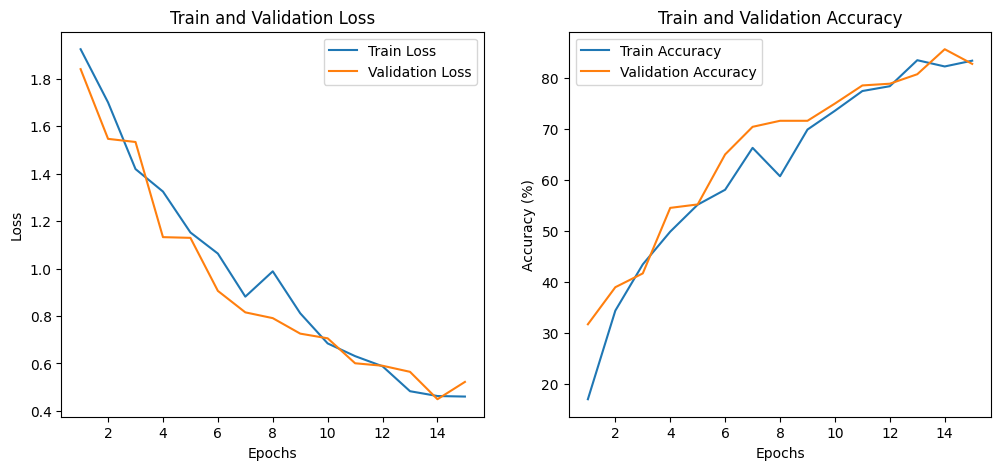

In [74]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()

In [80]:
import optuna

def objective(trial):
    # Define hyperparameters to be optimized
    hidden_size = trial.suggest_int('hidden_size', 128, 1024)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    
    # Create the model
    model = LSTMClassifier(num_channels, feature_size, hidden_size, num_layers, num_classes).to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    num_epochs = 15
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(features)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total

        # Print or log the training and validation performance
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Return the validation accuracy to be optimized by Optuna
    return val_accuracy

# Sample features to get num_channels and feature_size
sample_features, _ = next(iter(train_loader))
num_channels = sample_features.shape[2]
feature_size = sample_features.shape[3]

# Run Bayesian optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f'Best trial: {study.best_trial.number}')
print(f'Best value: {study.best_trial.value}')
print(f'Best parameters: {study.best_trial.params}')


[I 2024-06-22 16:58:57,495] A new study created in memory with name: no-name-311fdd9d-0177-428f-9700-7a5f04f49caf
C:\Users\Ahmad\AppData\Local\Temp\ipykernel_23736\3397563388.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
C:\Users\Ahmad\AppData\Local\Temp\ipykernel_23736\3397563388.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)


Epoch 1/15, Train Loss: 1.9272, Train Accuracy: 20.57%, Val Loss: 1.7397, Val Accuracy: 31.93%
Epoch 2/15, Train Loss: 1.7232, Train Accuracy: 29.15%, Val Loss: 1.7858, Val Accuracy: 26.86%
Epoch 3/15, Train Loss: 1.6674, Train Accuracy: 32.26%, Val Loss: 1.7758, Val Accuracy: 28.04%
Epoch 4/15, Train Loss: 1.6427, Train Accuracy: 30.66%, Val Loss: 1.5354, Val Accuracy: 33.78%
Epoch 5/15, Train Loss: 1.5539, Train Accuracy: 36.89%, Val Loss: 1.5140, Val Accuracy: 31.93%
Epoch 6/15, Train Loss: 1.5138, Train Accuracy: 35.94%, Val Loss: 1.4054, Val Accuracy: 39.86%
Epoch 7/15, Train Loss: 1.3840, Train Accuracy: 43.02%, Val Loss: 1.5201, Val Accuracy: 38.01%
Epoch 8/15, Train Loss: 1.3518, Train Accuracy: 45.09%, Val Loss: 1.6485, Val Accuracy: 36.99%
Epoch 9/15, Train Loss: 1.3123, Train Accuracy: 45.28%, Val Loss: 1.1223, Val Accuracy: 53.55%
Epoch 10/15, Train Loss: 1.1879, Train Accuracy: 50.94%, Val Loss: 1.3190, Val Accuracy: 46.62%
Epoch 11/15, Train Loss: 1.1784, Train Accuracy: 

[I 2024-06-22 17:17:13,575] Trial 0 finished with value: 61.317567567567565 and parameters: {'hidden_size': 972, 'num_layers': 3, 'learning_rate': 0.0013542469792615615, 'weight_decay': 8.197619369260915e-05}. Best is trial 0 with value: 61.317567567567565.


Epoch 15/15, Train Loss: 1.1508, Train Accuracy: 52.17%, Val Loss: 0.9611, Val Accuracy: 61.32%
Epoch 1/15, Train Loss: 1.9258, Train Accuracy: 16.98%, Val Loss: 1.8095, Val Accuracy: 27.70%
Epoch 2/15, Train Loss: 1.7810, Train Accuracy: 27.64%, Val Loss: 1.6836, Val Accuracy: 29.73%
Epoch 3/15, Train Loss: 1.7001, Train Accuracy: 30.09%, Val Loss: 1.6923, Val Accuracy: 30.91%
Epoch 4/15, Train Loss: 1.6623, Train Accuracy: 30.09%, Val Loss: 1.6329, Val Accuracy: 29.39%
Epoch 5/15, Train Loss: 1.6462, Train Accuracy: 29.81%, Val Loss: 1.6138, Val Accuracy: 33.45%
Epoch 6/15, Train Loss: 1.6084, Train Accuracy: 33.96%, Val Loss: 1.5136, Val Accuracy: 41.55%
Epoch 7/15, Train Loss: 1.5396, Train Accuracy: 37.83%, Val Loss: 1.4062, Val Accuracy: 43.07%
Epoch 8/15, Train Loss: 1.4717, Train Accuracy: 39.15%, Val Loss: 1.4264, Val Accuracy: 46.45%
Epoch 9/15, Train Loss: 1.5543, Train Accuracy: 37.26%, Val Loss: 1.5500, Val Accuracy: 36.32%
Epoch 10/15, Train Loss: 1.5600, Train Accuracy: 

[I 2024-06-22 17:19:58,679] Trial 1 finished with value: 47.46621621621622 and parameters: {'hidden_size': 220, 'num_layers': 3, 'learning_rate': 0.0012573408372835112, 'weight_decay': 0.00022129841422739268}. Best is trial 0 with value: 61.317567567567565.


Epoch 15/15, Train Loss: 1.3085, Train Accuracy: 48.02%, Val Loss: 1.2448, Val Accuracy: 47.47%
Epoch 1/15, Train Loss: 1.9189, Train Accuracy: 23.21%, Val Loss: 1.7815, Val Accuracy: 36.99%
Epoch 2/15, Train Loss: 1.6577, Train Accuracy: 37.36%, Val Loss: 1.4514, Val Accuracy: 44.43%
Epoch 3/15, Train Loss: 1.4102, Train Accuracy: 45.28%, Val Loss: 1.2714, Val Accuracy: 51.86%
Epoch 4/15, Train Loss: 1.1980, Train Accuracy: 56.42%, Val Loss: 0.9473, Val Accuracy: 67.74%
Epoch 5/15, Train Loss: 1.0122, Train Accuracy: 62.17%, Val Loss: 0.9137, Val Accuracy: 65.71%
Epoch 6/15, Train Loss: 0.8589, Train Accuracy: 69.25%, Val Loss: 0.7433, Val Accuracy: 72.64%
Epoch 7/15, Train Loss: 0.7467, Train Accuracy: 73.49%, Val Loss: 0.6300, Val Accuracy: 77.87%
Epoch 8/15, Train Loss: 0.6211, Train Accuracy: 77.36%, Val Loss: 0.6033, Val Accuracy: 79.56%
Epoch 9/15, Train Loss: 0.5460, Train Accuracy: 80.09%, Val Loss: 0.5856, Val Accuracy: 78.21%
Epoch 10/15, Train Loss: 0.4826, Train Accuracy: 

[I 2024-06-22 17:33:53,230] Trial 2 finished with value: 92.39864864864865 and parameters: {'hidden_size': 761, 'num_layers': 2, 'learning_rate': 0.00017678899346772607, 'weight_decay': 1.0280331356551523e-05}. Best is trial 2 with value: 92.39864864864865.


Epoch 15/15, Train Loss: 0.1522, Train Accuracy: 96.70%, Val Loss: 0.3054, Val Accuracy: 92.40%
Epoch 1/15, Train Loss: 1.9376, Train Accuracy: 17.45%, Val Loss: 1.9145, Val Accuracy: 27.03%
Epoch 2/15, Train Loss: 1.9060, Train Accuracy: 24.91%, Val Loss: 1.8839, Val Accuracy: 30.41%
Epoch 3/15, Train Loss: 1.8664, Train Accuracy: 31.98%, Val Loss: 1.8418, Val Accuracy: 35.14%
Epoch 4/15, Train Loss: 1.8294, Train Accuracy: 34.62%, Val Loss: 1.7824, Val Accuracy: 41.55%
Epoch 5/15, Train Loss: 1.7767, Train Accuracy: 38.58%, Val Loss: 1.7335, Val Accuracy: 42.57%
Epoch 6/15, Train Loss: 1.7201, Train Accuracy: 42.26%, Val Loss: 1.6631, Val Accuracy: 45.61%
Epoch 7/15, Train Loss: 1.6566, Train Accuracy: 45.57%, Val Loss: 1.6107, Val Accuracy: 45.95%
Epoch 8/15, Train Loss: 1.6072, Train Accuracy: 47.45%, Val Loss: 1.5639, Val Accuracy: 46.79%
Epoch 9/15, Train Loss: 1.5674, Train Accuracy: 47.08%, Val Loss: 1.5089, Val Accuracy: 50.34%
Epoch 10/15, Train Loss: 1.5100, Train Accuracy: 

[I 2024-06-22 17:36:49,599] Trial 3 finished with value: 63.851351351351354 and parameters: {'hidden_size': 196, 'num_layers': 1, 'learning_rate': 2.4039980625045224e-05, 'weight_decay': 0.0006840280616035869}. Best is trial 2 with value: 92.39864864864865.


Epoch 15/15, Train Loss: 1.3224, Train Accuracy: 60.75%, Val Loss: 1.2792, Val Accuracy: 63.85%
Epoch 1/15, Train Loss: 1.9302, Train Accuracy: 18.02%, Val Loss: 1.8280, Val Accuracy: 29.56%
Epoch 2/15, Train Loss: 1.7119, Train Accuracy: 30.85%, Val Loss: 1.5416, Val Accuracy: 38.34%
Epoch 3/15, Train Loss: 1.4495, Train Accuracy: 42.64%, Val Loss: 1.2975, Val Accuracy: 49.49%
Epoch 4/15, Train Loss: 1.2552, Train Accuracy: 52.36%, Val Loss: 1.0961, Val Accuracy: 57.26%
Epoch 5/15, Train Loss: 1.0679, Train Accuracy: 61.23%, Val Loss: 0.9365, Val Accuracy: 64.70%
Epoch 6/15, Train Loss: 0.9990, Train Accuracy: 60.09%, Val Loss: 0.8254, Val Accuracy: 70.44%
Epoch 7/15, Train Loss: 0.8291, Train Accuracy: 69.72%, Val Loss: 0.7659, Val Accuracy: 69.93%
Epoch 8/15, Train Loss: 0.7100, Train Accuracy: 71.13%, Val Loss: 0.9541, Val Accuracy: 65.54%
Epoch 9/15, Train Loss: 0.6966, Train Accuracy: 74.62%, Val Loss: 0.5713, Val Accuracy: 79.22%
Epoch 10/15, Train Loss: 0.6443, Train Accuracy: 

[I 2024-06-22 17:47:31,420] Trial 4 finished with value: 89.1891891891892 and parameters: {'hidden_size': 594, 'num_layers': 2, 'learning_rate': 0.0006136394870949332, 'weight_decay': 4.786225477878008e-06}. Best is trial 2 with value: 92.39864864864865.


Epoch 15/15, Train Loss: 0.2555, Train Accuracy: 92.55%, Val Loss: 0.3993, Val Accuracy: 89.19%
Epoch 1/15, Train Loss: 1.9459, Train Accuracy: 14.72%, Val Loss: 1.9450, Val Accuracy: 14.70%
Epoch 2/15, Train Loss: 1.9455, Train Accuracy: 14.72%, Val Loss: 1.9448, Val Accuracy: 14.70%
Epoch 3/15, Train Loss: 1.9446, Train Accuracy: 14.72%, Val Loss: 1.9443, Val Accuracy: 14.86%
Epoch 4/15, Train Loss: 1.9441, Train Accuracy: 14.72%, Val Loss: 1.9439, Val Accuracy: 14.86%
Epoch 5/15, Train Loss: 1.9448, Train Accuracy: 14.43%, Val Loss: 1.9437, Val Accuracy: 15.37%
Epoch 6/15, Train Loss: 1.9438, Train Accuracy: 16.89%, Val Loss: 1.9435, Val Accuracy: 15.37%
Epoch 7/15, Train Loss: 1.9432, Train Accuracy: 17.74%, Val Loss: 1.9434, Val Accuracy: 18.41%
Epoch 8/15, Train Loss: 1.9437, Train Accuracy: 18.30%, Val Loss: 1.9432, Val Accuracy: 19.26%
Epoch 9/15, Train Loss: 1.9431, Train Accuracy: 19.15%, Val Loss: 1.9431, Val Accuracy: 19.09%
Epoch 10/15, Train Loss: 1.9427, Train Accuracy: 

[I 2024-06-22 17:53:13,373] Trial 5 finished with value: 19.08783783783784 and parameters: {'hidden_size': 434, 'num_layers': 2, 'learning_rate': 3.395970394677121e-05, 'weight_decay': 0.00881564541881119}. Best is trial 2 with value: 92.39864864864865.


Epoch 15/15, Train Loss: 1.9424, Train Accuracy: 19.15%, Val Loss: 1.9428, Val Accuracy: 19.09%
Epoch 1/15, Train Loss: 2.1791, Train Accuracy: 13.87%, Val Loss: 1.9561, Val Accuracy: 14.70%
Epoch 2/15, Train Loss: 2.0321, Train Accuracy: 14.34%, Val Loss: 2.2078, Val Accuracy: 16.72%
Epoch 3/15, Train Loss: 1.9860, Train Accuracy: 14.25%, Val Loss: 1.9593, Val Accuracy: 14.53%
Epoch 4/15, Train Loss: 1.9863, Train Accuracy: 12.45%, Val Loss: 1.9731, Val Accuracy: 14.70%
Epoch 5/15, Train Loss: 1.9758, Train Accuracy: 13.68%, Val Loss: 1.9567, Val Accuracy: 14.36%
Epoch 6/15, Train Loss: 1.9856, Train Accuracy: 12.45%, Val Loss: 1.9476, Val Accuracy: 14.70%
Epoch 7/15, Train Loss: 2.4342, Train Accuracy: 13.87%, Val Loss: 2.0028, Val Accuracy: 14.36%
Epoch 8/15, Train Loss: 3.1911, Train Accuracy: 12.64%, Val Loss: 2.4939, Val Accuracy: 15.20%
Epoch 9/15, Train Loss: 2.0828, Train Accuracy: 14.81%, Val Loss: 1.9528, Val Accuracy: 15.20%
Epoch 10/15, Train Loss: 1.9893, Train Accuracy: 

[I 2024-06-22 17:56:34,587] Trial 6 finished with value: 14.695945945945946 and parameters: {'hidden_size': 175, 'num_layers': 3, 'learning_rate': 0.08448960359033168, 'weight_decay': 0.00048254987070023205}. Best is trial 2 with value: 92.39864864864865.


Epoch 15/15, Train Loss: 2.0163, Train Accuracy: 14.25%, Val Loss: 1.9893, Val Accuracy: 14.70%
Epoch 1/15, Train Loss: 1.9466, Train Accuracy: 14.72%, Val Loss: 1.9463, Val Accuracy: 14.70%
Epoch 2/15, Train Loss: 1.9455, Train Accuracy: 14.72%, Val Loss: 1.9452, Val Accuracy: 14.70%
Epoch 3/15, Train Loss: 1.9443, Train Accuracy: 14.81%, Val Loss: 1.9436, Val Accuracy: 14.86%
Epoch 4/15, Train Loss: 1.9423, Train Accuracy: 15.09%, Val Loss: 1.9407, Val Accuracy: 15.88%
Epoch 5/15, Train Loss: 1.9376, Train Accuracy: 21.98%, Val Loss: 1.9359, Val Accuracy: 22.47%
Epoch 6/15, Train Loss: 1.9313, Train Accuracy: 25.57%, Val Loss: 1.9275, Val Accuracy: 25.68%
Epoch 7/15, Train Loss: 1.9234, Train Accuracy: 24.81%, Val Loss: 1.9145, Val Accuracy: 29.22%
Epoch 8/15, Train Loss: 1.9080, Train Accuracy: 29.81%, Val Loss: 1.8965, Val Accuracy: 36.66%
Epoch 9/15, Train Loss: 1.8787, Train Accuracy: 33.87%, Val Loss: 1.8719, Val Accuracy: 36.15%
Epoch 10/15, Train Loss: 1.8603, Train Accuracy: 

[I 2024-06-22 18:02:04,678] Trial 7 finished with value: 39.358108108108105 and parameters: {'hidden_size': 403, 'num_layers': 3, 'learning_rate': 1.1470819708501607e-05, 'weight_decay': 3.7616455318215307e-06}. Best is trial 2 with value: 92.39864864864865.


Epoch 15/15, Train Loss: 1.6813, Train Accuracy: 36.60%, Val Loss: 1.6552, Val Accuracy: 39.36%
Epoch 1/15, Train Loss: 1.9397, Train Accuracy: 18.77%, Val Loss: 1.9172, Val Accuracy: 29.56%
Epoch 2/15, Train Loss: 1.9154, Train Accuracy: 25.47%, Val Loss: 1.8854, Val Accuracy: 34.80%
Epoch 3/15, Train Loss: 1.8767, Train Accuracy: 27.64%, Val Loss: 1.8398, Val Accuracy: 37.67%
Epoch 4/15, Train Loss: 1.8275, Train Accuracy: 32.83%, Val Loss: 1.7892, Val Accuracy: 32.94%
Epoch 5/15, Train Loss: 1.7727, Train Accuracy: 37.74%, Val Loss: 1.7122, Val Accuracy: 39.36%
Epoch 6/15, Train Loss: 1.7044, Train Accuracy: 38.58%, Val Loss: 1.6371, Val Accuracy: 41.55%
Epoch 7/15, Train Loss: 1.6349, Train Accuracy: 42.55%, Val Loss: 1.5478, Val Accuracy: 53.89%
Epoch 8/15, Train Loss: 1.5828, Train Accuracy: 47.45%, Val Loss: 1.5149, Val Accuracy: 51.35%
Epoch 9/15, Train Loss: 1.4878, Train Accuracy: 50.85%, Val Loss: 1.4340, Val Accuracy: 55.41%
Epoch 10/15, Train Loss: 1.4271, Train Accuracy: 

[I 2024-06-22 18:07:29,123] Trial 8 finished with value: 65.87837837837837 and parameters: {'hidden_size': 410, 'num_layers': 1, 'learning_rate': 3.8792063574140605e-05, 'weight_decay': 0.0027970192359738806}. Best is trial 2 with value: 92.39864864864865.


Epoch 15/15, Train Loss: 1.1695, Train Accuracy: 63.21%, Val Loss: 1.1543, Val Accuracy: 65.88%
Epoch 1/15, Train Loss: 1.9078, Train Accuracy: 21.51%, Val Loss: 1.7922, Val Accuracy: 29.90%
Epoch 2/15, Train Loss: 1.6726, Train Accuracy: 33.58%, Val Loss: 1.4853, Val Accuracy: 45.10%
Epoch 3/15, Train Loss: 1.4331, Train Accuracy: 43.68%, Val Loss: 1.5220, Val Accuracy: 38.34%
Epoch 4/15, Train Loss: 1.2639, Train Accuracy: 51.60%, Val Loss: 1.2077, Val Accuracy: 52.53%
Epoch 5/15, Train Loss: 1.1529, Train Accuracy: 57.08%, Val Loss: 1.0322, Val Accuracy: 59.29%
Epoch 6/15, Train Loss: 1.0534, Train Accuracy: 60.00%, Val Loss: 0.8964, Val Accuracy: 67.23%
Epoch 7/15, Train Loss: 0.9473, Train Accuracy: 64.91%, Val Loss: 0.8688, Val Accuracy: 67.40%
Epoch 8/15, Train Loss: 0.8728, Train Accuracy: 66.51%, Val Loss: 0.8318, Val Accuracy: 66.22%
Epoch 9/15, Train Loss: 0.8529, Train Accuracy: 68.49%, Val Loss: 1.0788, Val Accuracy: 62.33%
Epoch 10/15, Train Loss: 0.8147, Train Accuracy: 

[I 2024-06-22 18:18:17,627] Trial 9 finished with value: 91.38513513513513 and parameters: {'hidden_size': 593, 'num_layers': 2, 'learning_rate': 0.0005391424696492511, 'weight_decay': 7.757234549155772e-05}. Best is trial 2 with value: 92.39864864864865.


Epoch 15/15, Train Loss: 0.3933, Train Accuracy: 87.74%, Val Loss: 0.3612, Val Accuracy: 91.39%
Epoch 1/15, Train Loss: 2.4214, Train Accuracy: 15.85%, Val Loss: 2.8776, Val Accuracy: 14.36%
Epoch 2/15, Train Loss: 2.2134, Train Accuracy: 16.23%, Val Loss: 2.1142, Val Accuracy: 18.07%
Epoch 3/15, Train Loss: 2.1399, Train Accuracy: 16.23%, Val Loss: 2.7341, Val Accuracy: 14.19%
Epoch 4/15, Train Loss: 2.1782, Train Accuracy: 17.26%, Val Loss: 2.1223, Val Accuracy: 18.07%
Epoch 5/15, Train Loss: 2.1321, Train Accuracy: 12.74%, Val Loss: 2.3350, Val Accuracy: 13.68%
Epoch 6/15, Train Loss: 2.1040, Train Accuracy: 16.42%, Val Loss: 2.1670, Val Accuracy: 18.41%
Epoch 7/15, Train Loss: 2.0085, Train Accuracy: 19.81%, Val Loss: 2.1153, Val Accuracy: 14.19%
Epoch 8/15, Train Loss: 2.0228, Train Accuracy: 17.26%, Val Loss: 2.4913, Val Accuracy: 15.71%
Epoch 9/15, Train Loss: 2.1587, Train Accuracy: 16.60%, Val Loss: 2.1693, Val Accuracy: 14.70%
Epoch 10/15, Train Loss: 2.1341, Train Accuracy: 

[I 2024-06-22 18:35:06,804] Trial 10 finished with value: 17.39864864864865 and parameters: {'hidden_size': 910, 'num_layers': 1, 'learning_rate': 0.013478402569716937, 'weight_decay': 1.1824896353956877e-06}. Best is trial 2 with value: 92.39864864864865.


Epoch 15/15, Train Loss: 2.1058, Train Accuracy: 13.30%, Val Loss: 2.2443, Val Accuracy: 17.40%
Epoch 1/15, Train Loss: 1.9035, Train Accuracy: 22.92%, Val Loss: 1.7517, Val Accuracy: 32.26%
Epoch 2/15, Train Loss: 1.6644, Train Accuracy: 37.45%, Val Loss: 1.4272, Val Accuracy: 45.61%
Epoch 3/15, Train Loss: 1.3285, Train Accuracy: 50.09%, Val Loss: 1.1086, Val Accuracy: 57.09%
Epoch 4/15, Train Loss: 1.1189, Train Accuracy: 57.55%, Val Loss: 0.8982, Val Accuracy: 68.24%
Epoch 5/15, Train Loss: 0.9983, Train Accuracy: 61.13%, Val Loss: 0.8132, Val Accuracy: 72.80%
Epoch 6/15, Train Loss: 0.7889, Train Accuracy: 69.91%, Val Loss: 0.6589, Val Accuracy: 76.35%
Epoch 7/15, Train Loss: 0.7529, Train Accuracy: 70.75%, Val Loss: 0.6151, Val Accuracy: 79.90%
Epoch 8/15, Train Loss: 0.5571, Train Accuracy: 80.57%, Val Loss: 0.6260, Val Accuracy: 79.22%
Epoch 9/15, Train Loss: 0.5227, Train Accuracy: 81.04%, Val Loss: 0.4352, Val Accuracy: 86.82%
Epoch 10/15, Train Loss: 0.4594, Train Accuracy: 

[I 2024-06-22 18:48:16,145] Trial 11 finished with value: 92.9054054054054 and parameters: {'hidden_size': 718, 'num_layers': 2, 'learning_rate': 0.00023955414073079643, 'weight_decay': 2.937361914049454e-05}. Best is trial 11 with value: 92.9054054054054.


Epoch 15/15, Train Loss: 0.2952, Train Accuracy: 89.34%, Val Loss: 0.2944, Val Accuracy: 92.91%
Epoch 1/15, Train Loss: 1.9153, Train Accuracy: 20.85%, Val Loss: 1.8261, Val Accuracy: 30.24%
Epoch 2/15, Train Loss: 1.7079, Train Accuracy: 33.11%, Val Loss: 1.4940, Val Accuracy: 43.41%
Epoch 3/15, Train Loss: 1.4147, Train Accuracy: 46.51%, Val Loss: 1.2833, Val Accuracy: 55.57%
Epoch 4/15, Train Loss: 1.1797, Train Accuracy: 55.85%, Val Loss: 1.1432, Val Accuracy: 57.60%
Epoch 5/15, Train Loss: 1.0719, Train Accuracy: 59.72%, Val Loss: 0.9022, Val Accuracy: 68.75%
Epoch 6/15, Train Loss: 0.8919, Train Accuracy: 67.83%, Val Loss: 0.7322, Val Accuracy: 75.17%
Epoch 7/15, Train Loss: 0.8133, Train Accuracy: 69.34%, Val Loss: 0.7463, Val Accuracy: 72.80%
Epoch 8/15, Train Loss: 0.6943, Train Accuracy: 74.15%, Val Loss: 0.6415, Val Accuracy: 78.04%
Epoch 9/15, Train Loss: 0.5562, Train Accuracy: 80.85%, Val Loss: 0.5652, Val Accuracy: 80.24%
Epoch 10/15, Train Loss: 0.5122, Train Accuracy: 

[I 2024-06-22 19:03:03,050] Trial 12 finished with value: 94.25675675675676 and parameters: {'hidden_size': 781, 'num_layers': 2, 'learning_rate': 0.0001470101435973529, 'weight_decay': 1.734726592501401e-05}. Best is trial 12 with value: 94.25675675675676.


Epoch 15/15, Train Loss: 0.1540, Train Accuracy: 96.89%, Val Loss: 0.2724, Val Accuracy: 94.26%
Epoch 1/15, Train Loss: 1.9307, Train Accuracy: 20.75%, Val Loss: 1.8444, Val Accuracy: 31.08%
Epoch 2/15, Train Loss: 1.7219, Train Accuracy: 34.06%, Val Loss: 1.4749, Val Accuracy: 43.58%
Epoch 3/15, Train Loss: 1.4600, Train Accuracy: 44.34%, Val Loss: 1.1903, Val Accuracy: 57.94%
Epoch 4/15, Train Loss: 1.1915, Train Accuracy: 56.04%, Val Loss: 1.1404, Val Accuracy: 55.41%
Epoch 5/15, Train Loss: 1.0249, Train Accuracy: 61.89%, Val Loss: 0.8251, Val Accuracy: 75.17%
Epoch 6/15, Train Loss: 0.8623, Train Accuracy: 69.06%, Val Loss: 0.8997, Val Accuracy: 63.68%
Epoch 7/15, Train Loss: 0.7144, Train Accuracy: 74.15%, Val Loss: 0.7056, Val Accuracy: 73.31%
Epoch 8/15, Train Loss: 0.6571, Train Accuracy: 76.89%, Val Loss: 0.6087, Val Accuracy: 77.70%
Epoch 9/15, Train Loss: 0.6026, Train Accuracy: 80.28%, Val Loss: 0.5577, Val Accuracy: 80.07%
Epoch 10/15, Train Loss: 0.5379, Train Accuracy: 

[I 2024-06-22 19:17:16,714] Trial 13 finished with value: 94.76351351351352 and parameters: {'hidden_size': 774, 'num_layers': 2, 'learning_rate': 0.00014488263839179663, 'weight_decay': 1.8388399134981787e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1816, Train Accuracy: 95.28%, Val Loss: 0.2647, Val Accuracy: 94.76%
Epoch 1/15, Train Loss: 1.9214, Train Accuracy: 20.94%, Val Loss: 1.8374, Val Accuracy: 35.81%
Epoch 2/15, Train Loss: 1.7263, Train Accuracy: 34.53%, Val Loss: 1.5458, Val Accuracy: 43.92%
Epoch 3/15, Train Loss: 1.4562, Train Accuracy: 42.45%, Val Loss: 1.2620, Val Accuracy: 51.69%
Epoch 4/15, Train Loss: 1.2465, Train Accuracy: 55.19%, Val Loss: 1.3413, Val Accuracy: 50.00%
Epoch 5/15, Train Loss: 1.1451, Train Accuracy: 57.55%, Val Loss: 0.9317, Val Accuracy: 68.41%
Epoch 6/15, Train Loss: 0.9755, Train Accuracy: 64.43%, Val Loss: 0.8730, Val Accuracy: 69.26%
Epoch 7/15, Train Loss: 0.8161, Train Accuracy: 71.98%, Val Loss: 0.7385, Val Accuracy: 75.00%
Epoch 8/15, Train Loss: 0.7027, Train Accuracy: 75.09%, Val Loss: 0.7186, Val Accuracy: 76.01%
Epoch 9/15, Train Loss: 0.6463, Train Accuracy: 78.11%, Val Loss: 0.6282, Val Accuracy: 81.08%
Epoch 10/15, Train Loss: 0.5778, Train Accuracy: 

[I 2024-06-22 19:32:43,042] Trial 14 finished with value: 93.75 and parameters: {'hidden_size': 834, 'num_layers': 2, 'learning_rate': 9.40591286451669e-05, 'weight_decay': 2.5855261368269407e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3211, Train Accuracy: 90.28%, Val Loss: 0.3176, Val Accuracy: 93.75%
Epoch 1/15, Train Loss: 2.1647, Train Accuracy: 16.70%, Val Loss: 2.0489, Val Accuracy: 19.43%
Epoch 2/15, Train Loss: 1.9578, Train Accuracy: 18.21%, Val Loss: 1.9214, Val Accuracy: 19.26%
Epoch 3/15, Train Loss: 1.9380, Train Accuracy: 19.81%, Val Loss: 1.9931, Val Accuracy: 20.27%
Epoch 4/15, Train Loss: 1.8787, Train Accuracy: 24.72%, Val Loss: 1.9363, Val Accuracy: 19.59%
Epoch 5/15, Train Loss: 1.9446, Train Accuracy: 19.25%, Val Loss: 1.9294, Val Accuracy: 18.92%
Epoch 6/15, Train Loss: 1.8743, Train Accuracy: 24.25%, Val Loss: 1.8825, Val Accuracy: 20.27%
Epoch 7/15, Train Loss: 1.8675, Train Accuracy: 24.06%, Val Loss: 1.8031, Val Accuracy: 27.36%
Epoch 8/15, Train Loss: 1.8733, Train Accuracy: 24.15%, Val Loss: 1.8732, Val Accuracy: 25.17%
Epoch 9/15, Train Loss: 1.8930, Train Accuracy: 24.34%, Val Loss: 1.7906, Val Accuracy: 26.01%
Epoch 10/15, Train Loss: 1.8054, Train Accuracy: 

[I 2024-06-22 19:46:17,013] Trial 15 finished with value: 26.18243243243243 and parameters: {'hidden_size': 748, 'num_layers': 1, 'learning_rate': 0.005227620633384695, 'weight_decay': 1.919901925662339e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.8118, Train Accuracy: 26.70%, Val Loss: 1.7752, Val Accuracy: 26.18%
Epoch 1/15, Train Loss: 1.9289, Train Accuracy: 20.75%, Val Loss: 1.8454, Val Accuracy: 35.81%
Epoch 2/15, Train Loss: 1.7329, Train Accuracy: 35.47%, Val Loss: 1.5381, Val Accuracy: 43.92%
Epoch 3/15, Train Loss: 1.4635, Train Accuracy: 46.60%, Val Loss: 1.2934, Val Accuracy: 52.87%
Epoch 4/15, Train Loss: 1.2433, Train Accuracy: 53.30%, Val Loss: 1.2427, Val Accuracy: 55.57%
Epoch 5/15, Train Loss: 1.1395, Train Accuracy: 56.32%, Val Loss: 0.9043, Val Accuracy: 70.10%
Epoch 6/15, Train Loss: 0.8947, Train Accuracy: 67.55%, Val Loss: 0.8591, Val Accuracy: 69.09%
Epoch 7/15, Train Loss: 0.7597, Train Accuracy: 73.68%, Val Loss: 0.7109, Val Accuracy: 74.49%
Epoch 8/15, Train Loss: 0.6424, Train Accuracy: 78.11%, Val Loss: 0.6917, Val Accuracy: 77.53%
Epoch 9/15, Train Loss: 0.5835, Train Accuracy: 79.53%, Val Loss: 0.4714, Val Accuracy: 86.82%
Epoch 10/15, Train Loss: 0.4848, Train Accuracy: 

[I 2024-06-22 20:02:09,765] Trial 16 finished with value: 93.58108108108108 and parameters: {'hidden_size': 853, 'num_layers': 2, 'learning_rate': 0.00010672238407879577, 'weight_decay': 1.3352023979141917e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1910, Train Accuracy: 95.85%, Val Loss: 0.2919, Val Accuracy: 93.58%
Epoch 1/15, Train Loss: 2.1435, Train Accuracy: 17.36%, Val Loss: 1.9711, Val Accuracy: 23.14%
Epoch 2/15, Train Loss: 1.9441, Train Accuracy: 20.38%, Val Loss: 1.8988, Val Accuracy: 25.51%
Epoch 3/15, Train Loss: 1.8870, Train Accuracy: 19.81%, Val Loss: 1.8479, Val Accuracy: 17.57%
Epoch 4/15, Train Loss: 1.8346, Train Accuracy: 25.66%, Val Loss: 1.8288, Val Accuracy: 33.61%
Epoch 5/15, Train Loss: 1.8322, Train Accuracy: 27.45%, Val Loss: 1.8044, Val Accuracy: 26.18%
Epoch 6/15, Train Loss: 1.7540, Train Accuracy: 31.60%, Val Loss: 1.8877, Val Accuracy: 18.75%
Epoch 7/15, Train Loss: 1.7491, Train Accuracy: 31.60%, Val Loss: 1.6628, Val Accuracy: 33.28%
Epoch 8/15, Train Loss: 1.6972, Train Accuracy: 33.96%, Val Loss: 1.7055, Val Accuracy: 35.64%
Epoch 9/15, Train Loss: 1.6549, Train Accuracy: 34.34%, Val Loss: 1.5886, Val Accuracy: 40.54%
Epoch 10/15, Train Loss: 1.6565, Train Accuracy: 

[I 2024-06-22 20:21:54,764] Trial 17 finished with value: 45.608108108108105 and parameters: {'hidden_size': 990, 'num_layers': 1, 'learning_rate': 0.003909910286220563, 'weight_decay': 7.027985598013413e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.5538, Train Accuracy: 37.36%, Val Loss: 1.4547, Val Accuracy: 45.61%
Epoch 1/15, Train Loss: 1.8904, Train Accuracy: 23.11%, Val Loss: 1.7465, Val Accuracy: 32.94%
Epoch 2/15, Train Loss: 1.5893, Train Accuracy: 36.89%, Val Loss: 1.4814, Val Accuracy: 41.72%
Epoch 3/15, Train Loss: 1.3859, Train Accuracy: 46.89%, Val Loss: 1.2372, Val Accuracy: 50.68%
Epoch 4/15, Train Loss: 1.2026, Train Accuracy: 54.34%, Val Loss: 1.1078, Val Accuracy: 56.76%
Epoch 5/15, Train Loss: 1.0323, Train Accuracy: 61.04%, Val Loss: 1.1393, Val Accuracy: 54.39%
Epoch 6/15, Train Loss: 0.9579, Train Accuracy: 65.19%, Val Loss: 0.7665, Val Accuracy: 73.82%
Epoch 7/15, Train Loss: 0.7723, Train Accuracy: 70.19%, Val Loss: 0.7756, Val Accuracy: 71.79%
Epoch 8/15, Train Loss: 0.5923, Train Accuracy: 78.58%, Val Loss: 0.6043, Val Accuracy: 79.39%
Epoch 9/15, Train Loss: 0.6103, Train Accuracy: 76.04%, Val Loss: 0.6539, Val Accuracy: 75.34%
Epoch 10/15, Train Loss: 0.5128, Train Accuracy: 

[I 2024-06-22 20:33:56,936] Trial 18 finished with value: 93.41216216216216 and parameters: {'hidden_size': 660, 'num_layers': 2, 'learning_rate': 0.00033228399341061647, 'weight_decay': 5.130631964910047e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2365, Train Accuracy: 93.68%, Val Loss: 0.3314, Val Accuracy: 93.41%
Epoch 1/15, Train Loss: 1.9464, Train Accuracy: 14.53%, Val Loss: 1.9452, Val Accuracy: 14.36%
Epoch 2/15, Train Loss: 1.9449, Train Accuracy: 17.17%, Val Loss: 1.9424, Val Accuracy: 22.97%
Epoch 3/15, Train Loss: 1.9387, Train Accuracy: 20.66%, Val Loss: 1.9255, Val Accuracy: 27.36%
Epoch 4/15, Train Loss: 1.8760, Train Accuracy: 27.26%, Val Loss: 1.7696, Val Accuracy: 28.89%
Epoch 5/15, Train Loss: 1.7177, Train Accuracy: 29.72%, Val Loss: 1.5988, Val Accuracy: 36.49%
Epoch 6/15, Train Loss: 1.5469, Train Accuracy: 38.58%, Val Loss: 1.4279, Val Accuracy: 43.92%
Epoch 7/15, Train Loss: 1.4321, Train Accuracy: 42.08%, Val Loss: 1.2740, Val Accuracy: 51.18%
Epoch 8/15, Train Loss: 1.2878, Train Accuracy: 49.43%, Val Loss: 1.1732, Val Accuracy: 54.39%
Epoch 9/15, Train Loss: 1.1518, Train Accuracy: 55.09%, Val Loss: 1.0622, Val Accuracy: 57.09%
Epoch 10/15, Train Loss: 1.0860, Train Accuracy: 

[I 2024-06-22 20:49:23,679] Trial 19 finished with value: 74.1554054054054 and parameters: {'hidden_size': 824, 'num_layers': 3, 'learning_rate': 5.70301502433682e-05, 'weight_decay': 0.0001949318037455406}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.6827, Train Accuracy: 74.25%, Val Loss: 0.6687, Val Accuracy: 74.16%
Epoch 1/15, Train Loss: 1.9547, Train Accuracy: 13.77%, Val Loss: 1.9417, Val Accuracy: 20.78%
Epoch 2/15, Train Loss: 1.9254, Train Accuracy: 15.75%, Val Loss: 1.9140, Val Accuracy: 17.91%
Epoch 3/15, Train Loss: 1.9097, Train Accuracy: 16.98%, Val Loss: 1.9469, Val Accuracy: 16.55%
Epoch 4/15, Train Loss: 1.8894, Train Accuracy: 17.26%, Val Loss: 1.8728, Val Accuracy: 23.99%
Epoch 5/15, Train Loss: 1.8366, Train Accuracy: 23.11%, Val Loss: 1.7854, Val Accuracy: 27.03%
Epoch 6/15, Train Loss: 1.8103, Train Accuracy: 26.23%, Val Loss: 1.8399, Val Accuracy: 19.93%
Epoch 7/15, Train Loss: 1.8217, Train Accuracy: 25.00%, Val Loss: 1.7468, Val Accuracy: 28.04%
Epoch 8/15, Train Loss: 1.7839, Train Accuracy: 25.28%, Val Loss: 1.7894, Val Accuracy: 25.84%
Epoch 9/15, Train Loss: 1.7804, Train Accuracy: 27.74%, Val Loss: 1.7356, Val Accuracy: 28.21%
Epoch 10/15, Train Loss: 1.7223, Train Accuracy: 

[I 2024-06-22 20:54:33,401] Trial 20 finished with value: 37.5 and parameters: {'hidden_size': 503, 'num_layers': 2, 'learning_rate': 0.0033696990465641175, 'weight_decay': 2.6474776703620432e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.5547, Train Accuracy: 35.75%, Val Loss: 1.5562, Val Accuracy: 37.50%
Epoch 1/15, Train Loss: 1.9261, Train Accuracy: 17.92%, Val Loss: 1.8618, Val Accuracy: 28.89%
Epoch 2/15, Train Loss: 1.7484, Train Accuracy: 32.55%, Val Loss: 1.5451, Val Accuracy: 47.30%
Epoch 3/15, Train Loss: 1.4842, Train Accuracy: 44.81%, Val Loss: 1.2717, Val Accuracy: 53.38%
Epoch 4/15, Train Loss: 1.2343, Train Accuracy: 55.57%, Val Loss: 1.0484, Val Accuracy: 60.64%
Epoch 5/15, Train Loss: 1.0824, Train Accuracy: 59.62%, Val Loss: 0.9924, Val Accuracy: 60.64%
Epoch 6/15, Train Loss: 0.9803, Train Accuracy: 63.40%, Val Loss: 0.8106, Val Accuracy: 72.64%
Epoch 7/15, Train Loss: 0.7920, Train Accuracy: 71.32%, Val Loss: 0.6743, Val Accuracy: 77.03%
Epoch 8/15, Train Loss: 0.6677, Train Accuracy: 77.36%, Val Loss: 0.7801, Val Accuracy: 71.62%
Epoch 9/15, Train Loss: 0.6491, Train Accuracy: 75.00%, Val Loss: 0.5406, Val Accuracy: 84.12%
Epoch 10/15, Train Loss: 0.5076, Train Accuracy: 

[I 2024-06-22 21:10:44,354] Trial 21 finished with value: 91.04729729729729 and parameters: {'hidden_size': 870, 'num_layers': 2, 'learning_rate': 9.510734124654913e-05, 'weight_decay': 1.669969827978452e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2125, Train Accuracy: 94.15%, Val Loss: 0.3254, Val Accuracy: 91.05%
Epoch 1/15, Train Loss: 1.9235, Train Accuracy: 20.85%, Val Loss: 1.8551, Val Accuracy: 32.94%
Epoch 2/15, Train Loss: 1.7373, Train Accuracy: 35.19%, Val Loss: 1.5573, Val Accuracy: 43.58%
Epoch 3/15, Train Loss: 1.5168, Train Accuracy: 41.70%, Val Loss: 1.3510, Val Accuracy: 48.65%
Epoch 4/15, Train Loss: 1.2636, Train Accuracy: 53.40%, Val Loss: 1.0715, Val Accuracy: 63.01%
Epoch 5/15, Train Loss: 1.0956, Train Accuracy: 59.06%, Val Loss: 1.0217, Val Accuracy: 63.68%
Epoch 6/15, Train Loss: 0.9355, Train Accuracy: 66.98%, Val Loss: 0.8776, Val Accuracy: 67.06%
Epoch 7/15, Train Loss: 0.7990, Train Accuracy: 71.23%, Val Loss: 0.7403, Val Accuracy: 75.00%
Epoch 8/15, Train Loss: 0.6822, Train Accuracy: 76.70%, Val Loss: 0.7117, Val Accuracy: 75.17%
Epoch 9/15, Train Loss: 0.6845, Train Accuracy: 74.62%, Val Loss: 0.6256, Val Accuracy: 78.89%
Epoch 10/15, Train Loss: 0.5193, Train Accuracy: 

[I 2024-06-22 21:23:07,177] Trial 22 finished with value: 93.24324324324324 and parameters: {'hidden_size': 678, 'num_layers': 2, 'learning_rate': 0.00010535806375267788, 'weight_decay': 3.295360050509646e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2258, Train Accuracy: 94.81%, Val Loss: 0.2922, Val Accuracy: 93.24%
Epoch 1/15, Train Loss: 1.9439, Train Accuracy: 14.72%, Val Loss: 1.9385, Val Accuracy: 14.70%
Epoch 2/15, Train Loss: 1.9352, Train Accuracy: 18.49%, Val Loss: 1.9279, Val Accuracy: 20.61%
Epoch 3/15, Train Loss: 1.9251, Train Accuracy: 23.87%, Val Loss: 1.9088, Val Accuracy: 32.09%
Epoch 4/15, Train Loss: 1.8943, Train Accuracy: 30.28%, Val Loss: 1.8745, Val Accuracy: 32.09%
Epoch 5/15, Train Loss: 1.8518, Train Accuracy: 31.51%, Val Loss: 1.8204, Val Accuracy: 35.30%
Epoch 6/15, Train Loss: 1.8038, Train Accuracy: 32.55%, Val Loss: 1.7559, Val Accuracy: 36.15%
Epoch 7/15, Train Loss: 1.7447, Train Accuracy: 39.15%, Val Loss: 1.6825, Val Accuracy: 40.37%
Epoch 8/15, Train Loss: 1.6717, Train Accuracy: 42.45%, Val Loss: 1.6073, Val Accuracy: 43.07%
Epoch 9/15, Train Loss: 1.5960, Train Accuracy: 43.40%, Val Loss: 1.5316, Val Accuracy: 47.80%
Epoch 10/15, Train Loss: 1.5315, Train Accuracy: 

[I 2024-06-22 21:37:15,854] Trial 23 finished with value: 62.33108108108108 and parameters: {'hidden_size': 786, 'num_layers': 2, 'learning_rate': 1.261083584522863e-05, 'weight_decay': 1.690594038677147e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.2442, Train Accuracy: 58.02%, Val Loss: 1.1846, Val Accuracy: 62.33%
Epoch 1/15, Train Loss: 1.9115, Train Accuracy: 22.26%, Val Loss: 1.7372, Val Accuracy: 35.30%
Epoch 2/15, Train Loss: 1.6413, Train Accuracy: 36.13%, Val Loss: 1.4221, Val Accuracy: 42.06%
Epoch 3/15, Train Loss: 1.3782, Train Accuracy: 45.66%, Val Loss: 1.3524, Val Accuracy: 44.43%
Epoch 4/15, Train Loss: 1.2029, Train Accuracy: 54.72%, Val Loss: 0.9776, Val Accuracy: 64.86%
Epoch 5/15, Train Loss: 1.0777, Train Accuracy: 57.83%, Val Loss: 1.0107, Val Accuracy: 60.47%
Epoch 6/15, Train Loss: 0.8847, Train Accuracy: 66.98%, Val Loss: 0.7592, Val Accuracy: 71.96%
Epoch 7/15, Train Loss: 0.7610, Train Accuracy: 72.36%, Val Loss: 0.8203, Val Accuracy: 70.61%
Epoch 8/15, Train Loss: 0.6954, Train Accuracy: 74.81%, Val Loss: 0.6225, Val Accuracy: 78.89%
Epoch 9/15, Train Loss: 0.5686, Train Accuracy: 78.02%, Val Loss: 0.7779, Val Accuracy: 73.48%
Epoch 10/15, Train Loss: 0.5269, Train Accuracy: 

[I 2024-06-22 21:55:44,975] Trial 24 finished with value: 89.52702702702703 and parameters: {'hidden_size': 923, 'num_layers': 2, 'learning_rate': 0.00022921450502904063, 'weight_decay': 0.0001633009922313286}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2278, Train Accuracy: 91.79%, Val Loss: 0.3998, Val Accuracy: 89.53%
Epoch 1/15, Train Loss: 1.9367, Train Accuracy: 18.30%, Val Loss: 1.8968, Val Accuracy: 33.61%
Epoch 2/15, Train Loss: 1.8436, Train Accuracy: 32.55%, Val Loss: 1.7220, Val Accuracy: 41.39%
Epoch 3/15, Train Loss: 1.6416, Train Accuracy: 38.21%, Val Loss: 1.4878, Val Accuracy: 45.10%
Epoch 4/15, Train Loss: 1.4184, Train Accuracy: 47.74%, Val Loss: 1.3821, Val Accuracy: 48.14%
Epoch 5/15, Train Loss: 1.2914, Train Accuracy: 52.36%, Val Loss: 1.1583, Val Accuracy: 59.63%
Epoch 6/15, Train Loss: 1.1230, Train Accuracy: 60.28%, Val Loss: 0.9875, Val Accuracy: 67.57%
Epoch 7/15, Train Loss: 0.9801, Train Accuracy: 66.89%, Val Loss: 0.8657, Val Accuracy: 72.64%
Epoch 8/15, Train Loss: 0.8664, Train Accuracy: 70.66%, Val Loss: 0.7864, Val Accuracy: 73.82%
Epoch 9/15, Train Loss: 0.7608, Train Accuracy: 75.85%, Val Loss: 0.7715, Val Accuracy: 75.17%
Epoch 10/15, Train Loss: 0.6916, Train Accuracy: 

[I 2024-06-22 22:08:03,951] Trial 25 finished with value: 85.97972972972973 and parameters: {'hidden_size': 671, 'num_layers': 2, 'learning_rate': 6.066606552918908e-05, 'weight_decay': 8.562267368171235e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3868, Train Accuracy: 90.00%, Val Loss: 0.4591, Val Accuracy: 85.98%
Epoch 1/15, Train Loss: 1.9340, Train Accuracy: 16.23%, Val Loss: 1.8526, Val Accuracy: 21.96%
Epoch 2/15, Train Loss: 1.7623, Train Accuracy: 27.45%, Val Loss: 1.5211, Val Accuracy: 41.55%
Epoch 3/15, Train Loss: 1.5069, Train Accuracy: 39.91%, Val Loss: 1.3308, Val Accuracy: 45.78%
Epoch 4/15, Train Loss: 1.2935, Train Accuracy: 48.96%, Val Loss: 1.6713, Val Accuracy: 34.97%
Epoch 5/15, Train Loss: 1.2563, Train Accuracy: 51.32%, Val Loss: 1.6307, Val Accuracy: 40.88%
Epoch 6/15, Train Loss: 1.1934, Train Accuracy: 52.92%, Val Loss: 1.0905, Val Accuracy: 55.57%
Epoch 7/15, Train Loss: 1.0265, Train Accuracy: 58.87%, Val Loss: 1.3587, Val Accuracy: 50.34%
Epoch 8/15, Train Loss: 1.0111, Train Accuracy: 60.09%, Val Loss: 0.8995, Val Accuracy: 65.71%
Epoch 9/15, Train Loss: 0.9368, Train Accuracy: 63.77%, Val Loss: 1.1026, Val Accuracy: 54.90%
Epoch 10/15, Train Loss: 0.8684, Train Accuracy: 

[I 2024-06-22 22:22:54,413] Trial 26 finished with value: 75.0 and parameters: {'hidden_size': 816, 'num_layers': 3, 'learning_rate': 0.0005409111053540916, 'weight_decay': 5.402733718889359e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.6234, Train Accuracy: 76.98%, Val Loss: 0.6678, Val Accuracy: 75.00%
Epoch 1/15, Train Loss: 1.8812, Train Accuracy: 22.26%, Val Loss: 1.7139, Val Accuracy: 37.16%
Epoch 2/15, Train Loss: 1.6056, Train Accuracy: 41.98%, Val Loss: 1.3880, Val Accuracy: 50.00%
Epoch 3/15, Train Loss: 1.3631, Train Accuracy: 51.98%, Val Loss: 1.1997, Val Accuracy: 57.26%
Epoch 4/15, Train Loss: 1.1704, Train Accuracy: 59.34%, Val Loss: 1.0312, Val Accuracy: 64.36%
Epoch 5/15, Train Loss: 1.0262, Train Accuracy: 65.19%, Val Loss: 1.0210, Val Accuracy: 62.84%
Epoch 6/15, Train Loss: 0.9425, Train Accuracy: 68.30%, Val Loss: 0.8562, Val Accuracy: 71.79%
Epoch 7/15, Train Loss: 0.8242, Train Accuracy: 72.45%, Val Loss: 0.8492, Val Accuracy: 70.61%
Epoch 8/15, Train Loss: 0.7358, Train Accuracy: 76.32%, Val Loss: 0.6374, Val Accuracy: 84.12%
Epoch 9/15, Train Loss: 0.6634, Train Accuracy: 80.09%, Val Loss: 0.6009, Val Accuracy: 84.80%
Epoch 10/15, Train Loss: 0.6034, Train Accuracy: 

[I 2024-06-22 22:39:46,239] Trial 27 finished with value: 94.08783783783784 and parameters: {'hidden_size': 915, 'num_layers': 1, 'learning_rate': 0.00010179896003621303, 'weight_decay': 2.4236060618747714e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3252, Train Accuracy: 93.49%, Val Loss: 0.3368, Val Accuracy: 94.09%
Epoch 1/15, Train Loss: 1.9323, Train Accuracy: 18.58%, Val Loss: 1.8582, Val Accuracy: 27.53%
Epoch 2/15, Train Loss: 1.8386, Train Accuracy: 32.08%, Val Loss: 1.7474, Val Accuracy: 35.30%
Epoch 3/15, Train Loss: 1.7083, Train Accuracy: 38.96%, Val Loss: 1.5989, Val Accuracy: 46.96%
Epoch 4/15, Train Loss: 1.5749, Train Accuracy: 45.47%, Val Loss: 1.4970, Val Accuracy: 47.64%
Epoch 5/15, Train Loss: 1.4680, Train Accuracy: 49.91%, Val Loss: 1.3686, Val Accuracy: 52.87%
Epoch 6/15, Train Loss: 1.3472, Train Accuracy: 55.57%, Val Loss: 1.2940, Val Accuracy: 55.57%
Epoch 7/15, Train Loss: 1.2486, Train Accuracy: 58.21%, Val Loss: 1.1849, Val Accuracy: 60.98%
Epoch 8/15, Train Loss: 1.1995, Train Accuracy: 62.83%, Val Loss: 1.1143, Val Accuracy: 64.70%
Epoch 9/15, Train Loss: 1.1373, Train Accuracy: 62.64%, Val Loss: 1.0964, Val Accuracy: 63.01%
Epoch 10/15, Train Loss: 1.0724, Train Accuracy: 

[I 2024-06-22 22:59:17,933] Trial 28 finished with value: 78.54729729729729 and parameters: {'hidden_size': 1022, 'num_layers': 1, 'learning_rate': 2.3792816349196198e-05, 'weight_decay': 2.1512625685563696e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.8465, Train Accuracy: 77.92%, Val Loss: 0.8115, Val Accuracy: 78.55%
Epoch 1/15, Train Loss: 1.9903, Train Accuracy: 21.89%, Val Loss: 1.8617, Val Accuracy: 30.91%
Epoch 2/15, Train Loss: 1.8306, Train Accuracy: 30.66%, Val Loss: 1.7662, Val Accuracy: 37.50%
Epoch 3/15, Train Loss: 1.7061, Train Accuracy: 36.70%, Val Loss: 1.6416, Val Accuracy: 43.92%
Epoch 4/15, Train Loss: 1.5848, Train Accuracy: 46.04%, Val Loss: 1.5099, Val Accuracy: 48.14%
Epoch 5/15, Train Loss: 1.4697, Train Accuracy: 52.45%, Val Loss: 1.3798, Val Accuracy: 55.41%
Epoch 6/15, Train Loss: 1.3571, Train Accuracy: 53.11%, Val Loss: 1.2584, Val Accuracy: 63.01%
Epoch 7/15, Train Loss: 1.2367, Train Accuracy: 61.79%, Val Loss: 1.1677, Val Accuracy: 61.66%
Epoch 8/15, Train Loss: 1.1372, Train Accuracy: 64.53%, Val Loss: 1.0590, Val Accuracy: 70.27%
Epoch 9/15, Train Loss: 1.0830, Train Accuracy: 67.08%, Val Loss: 1.0257, Val Accuracy: 70.44%
Epoch 10/15, Train Loss: 0.9747, Train Accuracy: 

[I 2024-06-22 23:16:19,690] Trial 29 finished with value: 86.82432432432432 and parameters: {'hidden_size': 939, 'num_layers': 1, 'learning_rate': 0.0014212960848960028, 'weight_decay': 5.289577590552457e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.6342, Train Accuracy: 83.49%, Val Loss: 0.6235, Val Accuracy: 86.82%
Epoch 1/15, Train Loss: 1.9063, Train Accuracy: 20.66%, Val Loss: 1.7506, Val Accuracy: 33.28%
Epoch 2/15, Train Loss: 1.6356, Train Accuracy: 37.64%, Val Loss: 1.4829, Val Accuracy: 45.61%
Epoch 3/15, Train Loss: 1.3685, Train Accuracy: 50.09%, Val Loss: 1.1913, Val Accuracy: 59.46%
Epoch 4/15, Train Loss: 1.1671, Train Accuracy: 59.81%, Val Loss: 1.1367, Val Accuracy: 59.12%
Epoch 5/15, Train Loss: 1.0406, Train Accuracy: 64.25%, Val Loss: 0.9401, Val Accuracy: 65.88%
Epoch 6/15, Train Loss: 0.8948, Train Accuracy: 72.45%, Val Loss: 0.8644, Val Accuracy: 70.61%
Epoch 7/15, Train Loss: 0.8213, Train Accuracy: 73.11%, Val Loss: 0.7612, Val Accuracy: 75.34%
Epoch 8/15, Train Loss: 0.6766, Train Accuracy: 79.43%, Val Loss: 0.6330, Val Accuracy: 83.11%
Epoch 9/15, Train Loss: 0.6023, Train Accuracy: 83.21%, Val Loss: 0.5507, Val Accuracy: 84.97%
Epoch 10/15, Train Loss: 0.5126, Train Accuracy: 

[I 2024-06-22 23:23:32,603] Trial 30 finished with value: 94.76351351351352 and parameters: {'hidden_size': 535, 'num_layers': 1, 'learning_rate': 0.00019003546480690924, 'weight_decay': 1.0648511716444851e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2825, Train Accuracy: 95.47%, Val Loss: 0.3151, Val Accuracy: 94.76%
Epoch 1/15, Train Loss: 1.8576, Train Accuracy: 23.77%, Val Loss: 1.6643, Val Accuracy: 36.66%
Epoch 2/15, Train Loss: 1.6070, Train Accuracy: 38.58%, Val Loss: 1.3851, Val Accuracy: 49.83%
Epoch 3/15, Train Loss: 1.3513, Train Accuracy: 51.98%, Val Loss: 1.2636, Val Accuracy: 54.39%
Epoch 4/15, Train Loss: 1.1658, Train Accuracy: 57.26%, Val Loss: 1.0637, Val Accuracy: 63.18%
Epoch 5/15, Train Loss: 1.0461, Train Accuracy: 63.96%, Val Loss: 0.9235, Val Accuracy: 69.59%
Epoch 6/15, Train Loss: 0.9590, Train Accuracy: 65.66%, Val Loss: 0.8355, Val Accuracy: 76.01%
Epoch 7/15, Train Loss: 0.8182, Train Accuracy: 74.62%, Val Loss: 0.7265, Val Accuracy: 77.20%
Epoch 8/15, Train Loss: 0.7579, Train Accuracy: 76.23%, Val Loss: 0.6870, Val Accuracy: 80.57%
Epoch 9/15, Train Loss: 0.6872, Train Accuracy: 78.96%, Val Loss: 0.6810, Val Accuracy: 79.90%
Epoch 10/15, Train Loss: 0.6787, Train Accuracy: 

[I 2024-06-22 23:30:55,184] Trial 31 finished with value: 91.72297297297297 and parameters: {'hidden_size': 551, 'num_layers': 1, 'learning_rate': 0.00015450311611858364, 'weight_decay': 8.974068986868424e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3190, Train Accuracy: 93.49%, Val Loss: 0.3753, Val Accuracy: 91.72%
Epoch 1/15, Train Loss: 1.9259, Train Accuracy: 20.94%, Val Loss: 1.8460, Val Accuracy: 31.93%
Epoch 2/15, Train Loss: 1.8005, Train Accuracy: 31.04%, Val Loss: 1.7244, Val Accuracy: 40.37%
Epoch 3/15, Train Loss: 1.6930, Train Accuracy: 38.58%, Val Loss: 1.6123, Val Accuracy: 41.72%
Epoch 4/15, Train Loss: 1.5798, Train Accuracy: 45.75%, Val Loss: 1.4851, Val Accuracy: 53.38%
Epoch 5/15, Train Loss: 1.4607, Train Accuracy: 52.64%, Val Loss: 1.3384, Val Accuracy: 61.15%
Epoch 6/15, Train Loss: 1.3301, Train Accuracy: 58.77%, Val Loss: 1.2756, Val Accuracy: 60.81%
Epoch 7/15, Train Loss: 1.2657, Train Accuracy: 61.42%, Val Loss: 1.1829, Val Accuracy: 65.03%
Epoch 8/15, Train Loss: 1.1363, Train Accuracy: 63.96%, Val Loss: 1.0501, Val Accuracy: 68.75%
Epoch 9/15, Train Loss: 1.0400, Train Accuracy: 70.19%, Val Loss: 0.9985, Val Accuracy: 70.78%
Epoch 10/15, Train Loss: 0.9550, Train Accuracy: 

[I 2024-06-22 23:33:01,404] Trial 32 finished with value: 86.99324324324324 and parameters: {'hidden_size': 291, 'num_layers': 1, 'learning_rate': 0.0009581889622070792, 'weight_decay': 2.6509779099188303e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.6045, Train Accuracy: 88.02%, Val Loss: 0.6540, Val Accuracy: 86.99%
Epoch 1/15, Train Loss: 1.9151, Train Accuracy: 23.30%, Val Loss: 1.7795, Val Accuracy: 33.95%
Epoch 2/15, Train Loss: 1.6757, Train Accuracy: 39.43%, Val Loss: 1.5229, Val Accuracy: 46.11%
Epoch 3/15, Train Loss: 1.4905, Train Accuracy: 47.83%, Val Loss: 1.3502, Val Accuracy: 50.68%
Epoch 4/15, Train Loss: 1.3012, Train Accuracy: 58.30%, Val Loss: 1.1859, Val Accuracy: 58.45%
Epoch 5/15, Train Loss: 1.1985, Train Accuracy: 59.91%, Val Loss: 1.0575, Val Accuracy: 65.71%
Epoch 6/15, Train Loss: 1.0965, Train Accuracy: 62.74%, Val Loss: 0.9849, Val Accuracy: 67.23%
Epoch 7/15, Train Loss: 0.9359, Train Accuracy: 70.85%, Val Loss: 0.8391, Val Accuracy: 74.49%
Epoch 8/15, Train Loss: 0.8212, Train Accuracy: 74.91%, Val Loss: 0.7784, Val Accuracy: 75.68%
Epoch 9/15, Train Loss: 0.7272, Train Accuracy: 78.02%, Val Loss: 0.6709, Val Accuracy: 82.43%
Epoch 10/15, Train Loss: 0.6428, Train Accuracy: 

[I 2024-06-22 23:37:01,607] Trial 33 finished with value: 91.72297297297297 and parameters: {'hidden_size': 526, 'num_layers': 1, 'learning_rate': 0.0003533271902739327, 'weight_decay': 1.2744595047519312e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3505, Train Accuracy: 93.40%, Val Loss: 0.3932, Val Accuracy: 91.72%
Epoch 1/15, Train Loss: 1.8921, Train Accuracy: 21.13%, Val Loss: 1.6999, Val Accuracy: 42.40%
Epoch 2/15, Train Loss: 1.5885, Train Accuracy: 39.91%, Val Loss: 1.4442, Val Accuracy: 48.14%
Epoch 3/15, Train Loss: 1.3702, Train Accuracy: 50.57%, Val Loss: 1.1861, Val Accuracy: 57.60%
Epoch 4/15, Train Loss: 1.1517, Train Accuracy: 61.89%, Val Loss: 0.9976, Val Accuracy: 68.92%
Epoch 5/15, Train Loss: 1.0131, Train Accuracy: 64.25%, Val Loss: 0.9519, Val Accuracy: 68.41%
Epoch 6/15, Train Loss: 0.9203, Train Accuracy: 68.68%, Val Loss: 0.8366, Val Accuracy: 75.00%
Epoch 7/15, Train Loss: 0.7961, Train Accuracy: 73.87%, Val Loss: 0.7200, Val Accuracy: 77.36%
Epoch 8/15, Train Loss: 0.7055, Train Accuracy: 78.40%, Val Loss: 0.7165, Val Accuracy: 80.07%
Epoch 9/15, Train Loss: 0.6220, Train Accuracy: 81.89%, Val Loss: 0.5973, Val Accuracy: 82.77%
Epoch 10/15, Train Loss: 0.5613, Train Accuracy: 

[I 2024-06-22 23:48:37,147] Trial 34 finished with value: 89.52702702702703 and parameters: {'hidden_size': 639, 'num_layers': 1, 'learning_rate': 0.00016388529437522977, 'weight_decay': 4.7677447740195754e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3027, Train Accuracy: 94.25%, Val Loss: 0.4069, Val Accuracy: 89.53%
Epoch 1/15, Train Loss: 1.9225, Train Accuracy: 21.89%, Val Loss: 1.8107, Val Accuracy: 31.08%
Epoch 2/15, Train Loss: 1.7392, Train Accuracy: 33.68%, Val Loss: 1.5853, Val Accuracy: 45.78%
Epoch 3/15, Train Loss: 1.5413, Train Accuracy: 43.11%, Val Loss: 1.3569, Val Accuracy: 57.43%
Epoch 4/15, Train Loss: 1.3612, Train Accuracy: 53.96%, Val Loss: 1.2178, Val Accuracy: 58.61%
Epoch 5/15, Train Loss: 1.2224, Train Accuracy: 59.25%, Val Loss: 1.1282, Val Accuracy: 62.67%
Epoch 6/15, Train Loss: 1.1163, Train Accuracy: 63.77%, Val Loss: 1.0342, Val Accuracy: 67.40%
Epoch 7/15, Train Loss: 1.0191, Train Accuracy: 66.89%, Val Loss: 1.0112, Val Accuracy: 65.88%
Epoch 8/15, Train Loss: 0.9463, Train Accuracy: 71.32%, Val Loss: 0.9226, Val Accuracy: 71.28%
Epoch 9/15, Train Loss: 0.8778, Train Accuracy: 73.21%, Val Loss: 0.8133, Val Accuracy: 77.87%
Epoch 10/15, Train Loss: 0.8432, Train Accuracy: 

[I 2024-06-23 00:02:25,765] Trial 35 finished with value: 85.64189189189189 and parameters: {'hidden_size': 741, 'num_layers': 1, 'learning_rate': 5.540850187989934e-05, 'weight_decay': 3.617186693907401e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.5883, Train Accuracy: 85.38%, Val Loss: 0.5910, Val Accuracy: 85.64%
Epoch 1/15, Train Loss: 1.9459, Train Accuracy: 14.53%, Val Loss: 1.9453, Val Accuracy: 14.53%
Epoch 2/15, Train Loss: 1.9452, Train Accuracy: 14.53%, Val Loss: 1.9447, Val Accuracy: 14.53%
Epoch 3/15, Train Loss: 1.9446, Train Accuracy: 14.53%, Val Loss: 1.9439, Val Accuracy: 14.53%
Epoch 4/15, Train Loss: 1.9427, Train Accuracy: 14.53%, Val Loss: 1.9422, Val Accuracy: 14.53%
Epoch 5/15, Train Loss: 1.9407, Train Accuracy: 17.83%, Val Loss: 1.9388, Val Accuracy: 22.80%
Epoch 6/15, Train Loss: 1.9362, Train Accuracy: 23.87%, Val Loss: 1.9312, Val Accuracy: 24.83%
Epoch 7/15, Train Loss: 1.9249, Train Accuracy: 25.94%, Val Loss: 1.9129, Val Accuracy: 29.05%
Epoch 8/15, Train Loss: 1.8942, Train Accuracy: 29.72%, Val Loss: 1.8719, Val Accuracy: 30.24%
Epoch 9/15, Train Loss: 1.8425, Train Accuracy: 29.06%, Val Loss: 1.7952, Val Accuracy: 31.25%
Epoch 10/15, Train Loss: 1.7616, Train Accuracy: 

[I 2024-06-23 00:05:27,211] Trial 36 finished with value: 52.195945945945944 and parameters: {'hidden_size': 466, 'num_layers': 3, 'learning_rate': 2.0260820815922575e-05, 'weight_decay': 8.716970562698187e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.3858, Train Accuracy: 48.40%, Val Loss: 1.3412, Val Accuracy: 52.20%
Epoch 1/15, Train Loss: 1.9767, Train Accuracy: 17.26%, Val Loss: 1.8713, Val Accuracy: 29.56%
Epoch 2/15, Train Loss: 1.8470, Train Accuracy: 31.04%, Val Loss: 1.7572, Val Accuracy: 40.03%
Epoch 3/15, Train Loss: 1.7270, Train Accuracy: 37.74%, Val Loss: 1.6457, Val Accuracy: 46.62%
Epoch 4/15, Train Loss: 1.5916, Train Accuracy: 45.57%, Val Loss: 1.4909, Val Accuracy: 51.86%
Epoch 5/15, Train Loss: 1.4569, Train Accuracy: 50.19%, Val Loss: 1.3541, Val Accuracy: 57.94%
Epoch 6/15, Train Loss: 1.3257, Train Accuracy: 58.77%, Val Loss: 1.2054, Val Accuracy: 65.03%
Epoch 7/15, Train Loss: 1.2025, Train Accuracy: 62.55%, Val Loss: 1.1232, Val Accuracy: 67.91%
Epoch 8/15, Train Loss: 1.1106, Train Accuracy: 66.42%, Val Loss: 1.0505, Val Accuracy: 70.44%
Epoch 9/15, Train Loss: 1.0121, Train Accuracy: 69.72%, Val Loss: 0.9261, Val Accuracy: 75.00%
Epoch 10/15, Train Loss: 0.9157, Train Accuracy: 

[I 2024-06-23 00:21:26,129] Trial 37 finished with value: 89.02027027027027 and parameters: {'hidden_size': 874, 'num_layers': 1, 'learning_rate': 0.0009705713699223017, 'weight_decay': 1.4873464792148455e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.5672, Train Accuracy: 87.55%, Val Loss: 0.5418, Val Accuracy: 89.02%
Epoch 1/15, Train Loss: 1.9010, Train Accuracy: 22.55%, Val Loss: 1.7239, Val Accuracy: 36.66%
Epoch 2/15, Train Loss: 1.6682, Train Accuracy: 37.55%, Val Loss: 1.4710, Val Accuracy: 48.14%
Epoch 3/15, Train Loss: 1.4241, Train Accuracy: 51.42%, Val Loss: 1.2629, Val Accuracy: 56.59%
Epoch 4/15, Train Loss: 1.2318, Train Accuracy: 58.77%, Val Loss: 1.0837, Val Accuracy: 65.88%
Epoch 5/15, Train Loss: 1.1013, Train Accuracy: 64.43%, Val Loss: 0.9880, Val Accuracy: 66.22%
Epoch 6/15, Train Loss: 1.0071, Train Accuracy: 67.08%, Val Loss: 0.9444, Val Accuracy: 68.75%
Epoch 7/15, Train Loss: 0.8857, Train Accuracy: 74.15%, Val Loss: 0.8136, Val Accuracy: 74.83%
Epoch 8/15, Train Loss: 0.8002, Train Accuracy: 76.98%, Val Loss: 0.7898, Val Accuracy: 73.99%
Epoch 9/15, Train Loss: 0.7109, Train Accuracy: 79.72%, Val Loss: 0.6770, Val Accuracy: 80.74%
Epoch 10/15, Train Loss: 0.6048, Train Accuracy: 

[I 2024-06-23 00:23:45,117] Trial 38 finished with value: 90.70945945945945 and parameters: {'hidden_size': 330, 'num_layers': 1, 'learning_rate': 0.0003058459861424167, 'weight_decay': 5.724214892555167e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3109, Train Accuracy: 93.96%, Val Loss: 0.4242, Val Accuracy: 90.71%
Epoch 1/15, Train Loss: 1.9442, Train Accuracy: 17.45%, Val Loss: 1.9406, Val Accuracy: 31.42%
Epoch 2/15, Train Loss: 1.9278, Train Accuracy: 25.09%, Val Loss: 1.8909, Val Accuracy: 33.78%
Epoch 3/15, Train Loss: 1.8379, Train Accuracy: 29.72%, Val Loss: 1.7237, Val Accuracy: 32.43%
Epoch 4/15, Train Loss: 1.6718, Train Accuracy: 33.96%, Val Loss: 1.5853, Val Accuracy: 39.36%
Epoch 5/15, Train Loss: 1.5170, Train Accuracy: 41.04%, Val Loss: 1.4145, Val Accuracy: 43.41%
Epoch 6/15, Train Loss: 1.3807, Train Accuracy: 48.21%, Val Loss: 1.2216, Val Accuracy: 53.21%
Epoch 7/15, Train Loss: 1.2390, Train Accuracy: 53.58%, Val Loss: 1.1423, Val Accuracy: 57.09%
Epoch 8/15, Train Loss: 1.1432, Train Accuracy: 54.53%, Val Loss: 1.0295, Val Accuracy: 61.32%
Epoch 9/15, Train Loss: 1.0252, Train Accuracy: 61.23%, Val Loss: 0.9333, Val Accuracy: 64.02%
Epoch 10/15, Train Loss: 0.9289, Train Accuracy: 

[I 2024-06-23 00:46:02,621] Trial 39 finished with value: 82.26351351351352 and parameters: {'hidden_size': 966, 'num_layers': 3, 'learning_rate': 3.732224104424132e-05, 'weight_decay': 9.881643279098196e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.5888, Train Accuracy: 79.34%, Val Loss: 0.5678, Val Accuracy: 82.26%
Epoch 1/15, Train Loss: 1.9428, Train Accuracy: 17.08%, Val Loss: 1.9064, Val Accuracy: 25.68%
Epoch 2/15, Train Loss: 1.8996, Train Accuracy: 23.02%, Val Loss: 1.8548, Val Accuracy: 26.52%
Epoch 3/15, Train Loss: 1.8051, Train Accuracy: 27.64%, Val Loss: 1.7200, Val Accuracy: 30.91%
Epoch 4/15, Train Loss: 1.7369, Train Accuracy: 28.77%, Val Loss: 1.6420, Val Accuracy: 31.93%
Epoch 5/15, Train Loss: 1.6656, Train Accuracy: 31.79%, Val Loss: 1.6647, Val Accuracy: 33.61%
Epoch 6/15, Train Loss: 1.6230, Train Accuracy: 33.58%, Val Loss: 1.5348, Val Accuracy: 32.09%
Epoch 7/15, Train Loss: 1.5799, Train Accuracy: 33.87%, Val Loss: 1.5344, Val Accuracy: 40.37%
Epoch 8/15, Train Loss: 1.5287, Train Accuracy: 37.55%, Val Loss: 1.4793, Val Accuracy: 39.53%
Epoch 9/15, Train Loss: 1.4658, Train Accuracy: 41.13%, Val Loss: 1.8924, Val Accuracy: 27.36%
Epoch 10/15, Train Loss: 1.5623, Train Accuracy: 

[I 2024-06-23 00:57:23,662] Trial 40 finished with value: 31.756756756756758 and parameters: {'hidden_size': 621, 'num_layers': 2, 'learning_rate': 0.0017996014378261849, 'weight_decay': 0.0003646667816190982}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.1846, Train Accuracy: 52.17%, Val Loss: 1.5903, Val Accuracy: 31.76%
Epoch 1/15, Train Loss: 1.9336, Train Accuracy: 18.68%, Val Loss: 1.8866, Val Accuracy: 32.26%
Epoch 2/15, Train Loss: 1.8056, Train Accuracy: 34.81%, Val Loss: 1.6167, Val Accuracy: 42.06%
Epoch 3/15, Train Loss: 1.5411, Train Accuracy: 41.04%, Val Loss: 1.3226, Val Accuracy: 53.04%
Epoch 4/15, Train Loss: 1.3259, Train Accuracy: 52.55%, Val Loss: 1.1812, Val Accuracy: 55.07%
Epoch 5/15, Train Loss: 1.1162, Train Accuracy: 60.09%, Val Loss: 0.9851, Val Accuracy: 65.54%
Epoch 6/15, Train Loss: 0.9487, Train Accuracy: 66.70%, Val Loss: 0.8655, Val Accuracy: 68.07%
Epoch 7/15, Train Loss: 0.8754, Train Accuracy: 69.15%, Val Loss: 0.7474, Val Accuracy: 76.35%
Epoch 8/15, Train Loss: 0.7359, Train Accuracy: 75.00%, Val Loss: 0.6486, Val Accuracy: 80.57%
Epoch 9/15, Train Loss: 0.6405, Train Accuracy: 78.77%, Val Loss: 0.6593, Val Accuracy: 80.57%
Epoch 10/15, Train Loss: 0.5742, Train Accuracy: 

[I 2024-06-23 01:10:10,077] Trial 41 finished with value: 93.07432432432432 and parameters: {'hidden_size': 710, 'num_layers': 2, 'learning_rate': 9.104425692402949e-05, 'weight_decay': 2.4543564173506274e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2599, Train Accuracy: 93.58%, Val Loss: 0.3245, Val Accuracy: 93.07%
Epoch 1/15, Train Loss: 1.9113, Train Accuracy: 20.28%, Val Loss: 1.8109, Val Accuracy: 27.53%
Epoch 2/15, Train Loss: 1.6958, Train Accuracy: 33.58%, Val Loss: 1.5697, Val Accuracy: 39.70%
Epoch 3/15, Train Loss: 1.4142, Train Accuracy: 46.60%, Val Loss: 1.3609, Val Accuracy: 47.30%
Epoch 4/15, Train Loss: 1.2057, Train Accuracy: 54.53%, Val Loss: 1.0002, Val Accuracy: 62.50%
Epoch 5/15, Train Loss: 1.0075, Train Accuracy: 63.11%, Val Loss: 1.0917, Val Accuracy: 57.60%
Epoch 6/15, Train Loss: 0.9109, Train Accuracy: 66.70%, Val Loss: 0.7314, Val Accuracy: 75.68%
Epoch 7/15, Train Loss: 0.6844, Train Accuracy: 76.42%, Val Loss: 0.6126, Val Accuracy: 78.89%
Epoch 8/15, Train Loss: 0.5914, Train Accuracy: 78.58%, Val Loss: 0.5733, Val Accuracy: 79.73%
Epoch 9/15, Train Loss: 0.5503, Train Accuracy: 78.58%, Val Loss: 0.5322, Val Accuracy: 82.94%
Epoch 10/15, Train Loss: 0.4776, Train Accuracy: 

[I 2024-06-23 01:24:37,143] Trial 42 finished with value: 93.07432432432432 and parameters: {'hidden_size': 801, 'num_layers': 2, 'learning_rate': 0.00015115710594271076, 'weight_decay': 3.210097053564645e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2094, Train Accuracy: 94.25%, Val Loss: 0.2983, Val Accuracy: 93.07%
Epoch 1/15, Train Loss: 1.9401, Train Accuracy: 17.74%, Val Loss: 1.9062, Val Accuracy: 25.84%
Epoch 2/15, Train Loss: 1.8349, Train Accuracy: 29.43%, Val Loss: 1.6962, Val Accuracy: 37.50%
Epoch 3/15, Train Loss: 1.6042, Train Accuracy: 39.72%, Val Loss: 1.4599, Val Accuracy: 42.06%
Epoch 4/15, Train Loss: 1.3646, Train Accuracy: 48.77%, Val Loss: 1.1462, Val Accuracy: 58.28%
Epoch 5/15, Train Loss: 1.1584, Train Accuracy: 57.55%, Val Loss: 1.0584, Val Accuracy: 59.97%
Epoch 6/15, Train Loss: 1.0002, Train Accuracy: 64.81%, Val Loss: 0.8802, Val Accuracy: 68.75%
Epoch 7/15, Train Loss: 0.9080, Train Accuracy: 67.92%, Val Loss: 0.7785, Val Accuracy: 73.82%
Epoch 8/15, Train Loss: 0.8444, Train Accuracy: 68.49%, Val Loss: 0.7589, Val Accuracy: 72.30%
Epoch 9/15, Train Loss: 0.6773, Train Accuracy: 76.13%, Val Loss: 0.8054, Val Accuracy: 70.27%
Epoch 10/15, Train Loss: 0.6391, Train Accuracy: 

[I 2024-06-23 01:41:31,583] Trial 43 finished with value: 92.9054054054054 and parameters: {'hidden_size': 881, 'num_layers': 2, 'learning_rate': 7.456703438218599e-05, 'weight_decay': 0.00012020557146619485}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2944, Train Accuracy: 91.79%, Val Loss: 0.3273, Val Accuracy: 92.91%
Epoch 1/15, Train Loss: 1.8983, Train Accuracy: 21.89%, Val Loss: 1.7568, Val Accuracy: 30.74%
Epoch 2/15, Train Loss: 1.6218, Train Accuracy: 36.32%, Val Loss: 1.4025, Val Accuracy: 46.96%
Epoch 3/15, Train Loss: 1.3501, Train Accuracy: 48.68%, Val Loss: 1.2994, Val Accuracy: 48.65%
Epoch 4/15, Train Loss: 1.1471, Train Accuracy: 55.85%, Val Loss: 0.9919, Val Accuracy: 58.78%
Epoch 5/15, Train Loss: 0.9979, Train Accuracy: 61.89%, Val Loss: 0.8777, Val Accuracy: 67.06%
Epoch 6/15, Train Loss: 0.9008, Train Accuracy: 64.81%, Val Loss: 0.8002, Val Accuracy: 70.95%
Epoch 7/15, Train Loss: 0.8391, Train Accuracy: 67.36%, Val Loss: 0.7958, Val Accuracy: 68.07%
Epoch 8/15, Train Loss: 0.6857, Train Accuracy: 75.57%, Val Loss: 0.5450, Val Accuracy: 81.42%
Epoch 9/15, Train Loss: 0.5935, Train Accuracy: 78.49%, Val Loss: 0.5184, Val Accuracy: 83.61%
Epoch 10/15, Train Loss: 0.4882, Train Accuracy: 

[I 2024-06-23 01:56:56,370] Trial 44 finished with value: 92.39864864864865 and parameters: {'hidden_size': 829, 'num_layers': 2, 'learning_rate': 0.0004323068456179133, 'weight_decay': 1.6602444622827167e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1986, Train Accuracy: 93.96%, Val Loss: 0.2933, Val Accuracy: 92.40%
Epoch 1/15, Train Loss: 1.8943, Train Accuracy: 22.83%, Val Loss: 1.7972, Val Accuracy: 28.55%
Epoch 2/15, Train Loss: 1.6442, Train Accuracy: 35.19%, Val Loss: 1.3598, Val Accuracy: 48.99%
Epoch 3/15, Train Loss: 1.3245, Train Accuracy: 51.51%, Val Loss: 1.1451, Val Accuracy: 58.61%
Epoch 4/15, Train Loss: 1.1263, Train Accuracy: 59.72%, Val Loss: 1.0408, Val Accuracy: 65.20%
Epoch 5/15, Train Loss: 0.9575, Train Accuracy: 64.25%, Val Loss: 0.9466, Val Accuracy: 64.02%
Epoch 6/15, Train Loss: 0.7954, Train Accuracy: 69.43%, Val Loss: 0.6203, Val Accuracy: 77.87%
Epoch 7/15, Train Loss: 0.6135, Train Accuracy: 78.11%, Val Loss: 0.6134, Val Accuracy: 79.56%
Epoch 8/15, Train Loss: 0.5089, Train Accuracy: 81.70%, Val Loss: 0.6487, Val Accuracy: 76.52%
Epoch 9/15, Train Loss: 0.4700, Train Accuracy: 83.77%, Val Loss: 0.4122, Val Accuracy: 88.34%
Epoch 10/15, Train Loss: 0.3440, Train Accuracy: 

[I 2024-06-23 02:11:10,243] Trial 45 finished with value: 94.08783783783784 and parameters: {'hidden_size': 770, 'num_layers': 2, 'learning_rate': 0.00020799248417802138, 'weight_decay': 3.94312586556349e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1117, Train Accuracy: 97.55%, Val Loss: 0.2975, Val Accuracy: 94.09%
Epoch 1/15, Train Loss: 4.8952, Train Accuracy: 16.51%, Val Loss: 3.7633, Val Accuracy: 12.84%
Epoch 2/15, Train Loss: 3.2738, Train Accuracy: 14.72%, Val Loss: 3.1777, Val Accuracy: 14.36%
Epoch 3/15, Train Loss: 2.8854, Train Accuracy: 14.53%, Val Loss: 3.6366, Val Accuracy: 14.53%
Epoch 4/15, Train Loss: 2.7369, Train Accuracy: 16.04%, Val Loss: 2.7878, Val Accuracy: 14.70%
Epoch 5/15, Train Loss: 2.7399, Train Accuracy: 13.49%, Val Loss: 3.0249, Val Accuracy: 14.70%
Epoch 6/15, Train Loss: 2.7206, Train Accuracy: 15.47%, Val Loss: 2.5989, Val Accuracy: 14.53%
Epoch 7/15, Train Loss: 2.7690, Train Accuracy: 14.15%, Val Loss: 2.4375, Val Accuracy: 14.53%
Epoch 8/15, Train Loss: 3.2431, Train Accuracy: 15.09%, Val Loss: 3.4291, Val Accuracy: 14.70%
Epoch 9/15, Train Loss: 3.1062, Train Accuracy: 13.49%, Val Loss: 3.3179, Val Accuracy: 12.84%
Epoch 10/15, Train Loss: 3.6513, Train Accuracy: 

[I 2024-06-23 02:25:34,403] Trial 46 finished with value: 14.695945945945946 and parameters: {'hidden_size': 780, 'num_layers': 2, 'learning_rate': 0.06692427644745011, 'weight_decay': 4.0830850848046724e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 4.5673, Train Accuracy: 14.43%, Val Loss: 5.7962, Val Accuracy: 14.70%
Epoch 1/15, Train Loss: 1.9587, Train Accuracy: 18.30%, Val Loss: 1.8754, Val Accuracy: 28.21%
Epoch 2/15, Train Loss: 1.8344, Train Accuracy: 32.26%, Val Loss: 1.7654, Val Accuracy: 36.49%
Epoch 3/15, Train Loss: 1.7243, Train Accuracy: 39.15%, Val Loss: 1.6653, Val Accuracy: 46.28%
Epoch 4/15, Train Loss: 1.6058, Train Accuracy: 44.81%, Val Loss: 1.5230, Val Accuracy: 50.84%
Epoch 5/15, Train Loss: 1.4730, Train Accuracy: 51.89%, Val Loss: 1.4122, Val Accuracy: 57.60%
Epoch 6/15, Train Loss: 1.3674, Train Accuracy: 54.62%, Val Loss: 1.2778, Val Accuracy: 61.49%
Epoch 7/15, Train Loss: 1.2504, Train Accuracy: 59.62%, Val Loss: 1.1512, Val Accuracy: 66.72%
Epoch 8/15, Train Loss: 1.1259, Train Accuracy: 64.91%, Val Loss: 1.0727, Val Accuracy: 65.88%
Epoch 9/15, Train Loss: 1.0489, Train Accuracy: 68.68%, Val Loss: 1.0104, Val Accuracy: 70.27%
Epoch 10/15, Train Loss: 0.9910, Train Accuracy: 

[I 2024-06-23 02:36:28,045] Trial 47 finished with value: 88.3445945945946 and parameters: {'hidden_size': 602, 'num_layers': 1, 'learning_rate': 0.0007208699295161564, 'weight_decay': 2.0098216633212247e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.6118, Train Accuracy: 84.53%, Val Loss: 0.6019, Val Accuracy: 88.34%
Epoch 1/15, Train Loss: 1.9186, Train Accuracy: 21.23%, Val Loss: 1.7482, Val Accuracy: 33.61%
Epoch 2/15, Train Loss: 1.6990, Train Accuracy: 35.57%, Val Loss: 1.4640, Val Accuracy: 50.51%
Epoch 3/15, Train Loss: 1.4471, Train Accuracy: 48.02%, Val Loss: 1.2929, Val Accuracy: 55.91%
Epoch 4/15, Train Loss: 1.3034, Train Accuracy: 52.74%, Val Loss: 1.0812, Val Accuracy: 65.54%
Epoch 5/15, Train Loss: 1.1089, Train Accuracy: 61.04%, Val Loss: 0.9475, Val Accuracy: 68.75%
Epoch 6/15, Train Loss: 0.9201, Train Accuracy: 70.66%, Val Loss: 0.8487, Val Accuracy: 70.44%
Epoch 7/15, Train Loss: 0.8437, Train Accuracy: 71.42%, Val Loss: 0.7443, Val Accuracy: 79.56%
Epoch 8/15, Train Loss: 0.7934, Train Accuracy: 74.81%, Val Loss: 0.6748, Val Accuracy: 78.89%
Epoch 9/15, Train Loss: 0.6347, Train Accuracy: 81.89%, Val Loss: 0.5944, Val Accuracy: 83.95%
Epoch 10/15, Train Loss: 0.5358, Train Accuracy: 

[I 2024-06-23 02:49:20,072] Trial 48 finished with value: 93.58108108108108 and parameters: {'hidden_size': 718, 'num_layers': 1, 'learning_rate': 0.00022699914669798823, 'weight_decay': 1.0570449355787955e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2722, Train Accuracy: 94.81%, Val Loss: 0.3244, Val Accuracy: 93.58%
Epoch 1/15, Train Loss: 1.9453, Train Accuracy: 14.72%, Val Loss: 1.9444, Val Accuracy: 17.74%
Epoch 2/15, Train Loss: 1.9439, Train Accuracy: 17.74%, Val Loss: 1.9434, Val Accuracy: 14.70%
Epoch 3/15, Train Loss: 1.9433, Train Accuracy: 16.42%, Val Loss: 1.9429, Val Accuracy: 17.91%
Epoch 4/15, Train Loss: 1.9418, Train Accuracy: 14.91%, Val Loss: 1.9425, Val Accuracy: 14.70%
Epoch 5/15, Train Loss: 1.9423, Train Accuracy: 14.72%, Val Loss: 1.9420, Val Accuracy: 14.70%
Epoch 6/15, Train Loss: 1.9423, Train Accuracy: 15.94%, Val Loss: 1.9416, Val Accuracy: 19.26%
Epoch 7/15, Train Loss: 1.9416, Train Accuracy: 21.98%, Val Loss: 1.9414, Val Accuracy: 23.48%
Epoch 8/15, Train Loss: 1.9410, Train Accuracy: 18.30%, Val Loss: 1.9411, Val Accuracy: 16.89%
Epoch 9/15, Train Loss: 1.9410, Train Accuracy: 17.83%, Val Loss: 1.9407, Val Accuracy: 20.27%
Epoch 10/15, Train Loss: 1.9410, Train Accuracy: 

[I 2024-06-23 03:07:29,664] Trial 49 finished with value: 18.91891891891892 and parameters: {'hidden_size': 904, 'num_layers': 2, 'learning_rate': 3.726828203369147e-05, 'weight_decay': 0.0063630830739473485}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.9374, Train Accuracy: 18.02%, Val Loss: 1.9368, Val Accuracy: 18.92%
Epoch 1/15, Train Loss: 1.9457, Train Accuracy: 13.77%, Val Loss: 1.9455, Val Accuracy: 16.89%
Epoch 2/15, Train Loss: 1.9456, Train Accuracy: 16.79%, Val Loss: 1.9451, Val Accuracy: 14.70%
Epoch 3/15, Train Loss: 1.9449, Train Accuracy: 16.23%, Val Loss: 1.9452, Val Accuracy: 16.22%
Epoch 4/15, Train Loss: 1.9449, Train Accuracy: 14.72%, Val Loss: 1.9452, Val Accuracy: 14.70%
Epoch 5/15, Train Loss: 1.9448, Train Accuracy: 14.62%, Val Loss: 1.9452, Val Accuracy: 15.37%
Epoch 6/15, Train Loss: 1.9444, Train Accuracy: 17.55%, Val Loss: 1.9450, Val Accuracy: 17.91%
Epoch 7/15, Train Loss: 1.9440, Train Accuracy: 17.92%, Val Loss: 1.9447, Val Accuracy: 20.27%
Epoch 8/15, Train Loss: 1.9440, Train Accuracy: 17.26%, Val Loss: 1.9440, Val Accuracy: 21.11%
Epoch 9/15, Train Loss: 1.9420, Train Accuracy: 18.49%, Val Loss: 1.9402, Val Accuracy: 14.70%
Epoch 10/15, Train Loss: 1.9255, Train Accuracy: 

[I 2024-06-23 03:17:49,815] Trial 50 finished with value: 36.148648648648646 and parameters: {'hidden_size': 578, 'num_layers': 3, 'learning_rate': 0.00012938776074382572, 'weight_decay': 0.0010171096042685805}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.6242, Train Accuracy: 31.79%, Val Loss: 1.5550, Val Accuracy: 36.15%
Epoch 1/15, Train Loss: 1.8995, Train Accuracy: 21.51%, Val Loss: 1.7342, Val Accuracy: 35.30%
Epoch 2/15, Train Loss: 1.6659, Train Accuracy: 35.28%, Val Loss: 1.4260, Val Accuracy: 50.00%
Epoch 3/15, Train Loss: 1.3382, Train Accuracy: 48.96%, Val Loss: 1.0866, Val Accuracy: 62.33%
Epoch 4/15, Train Loss: 1.0485, Train Accuracy: 61.32%, Val Loss: 1.0314, Val Accuracy: 60.47%
Epoch 5/15, Train Loss: 0.9398, Train Accuracy: 64.15%, Val Loss: 0.8216, Val Accuracy: 69.93%
Epoch 6/15, Train Loss: 0.7762, Train Accuracy: 72.26%, Val Loss: 0.6367, Val Accuracy: 78.89%
Epoch 7/15, Train Loss: 0.6375, Train Accuracy: 77.08%, Val Loss: 0.6514, Val Accuracy: 77.03%
Epoch 8/15, Train Loss: 0.6398, Train Accuracy: 76.42%, Val Loss: 0.7219, Val Accuracy: 72.64%
Epoch 9/15, Train Loss: 0.5880, Train Accuracy: 78.87%, Val Loss: 0.4687, Val Accuracy: 86.82%
Epoch 10/15, Train Loss: 0.3585, Train Accuracy: 

[I 2024-06-23 03:31:57,013] Trial 51 finished with value: 94.76351351351352 and parameters: {'hidden_size': 762, 'num_layers': 2, 'learning_rate': 0.00021437192162322444, 'weight_decay': 6.56034173996194e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1427, Train Accuracy: 96.23%, Val Loss: 0.2631, Val Accuracy: 94.76%
Epoch 1/15, Train Loss: 1.8951, Train Accuracy: 21.13%, Val Loss: 1.7634, Val Accuracy: 31.76%
Epoch 2/15, Train Loss: 1.6275, Train Accuracy: 34.91%, Val Loss: 1.3241, Val Accuracy: 51.86%
Epoch 3/15, Train Loss: 1.3299, Train Accuracy: 48.77%, Val Loss: 1.1624, Val Accuracy: 56.76%
Epoch 4/15, Train Loss: 1.1424, Train Accuracy: 57.36%, Val Loss: 0.9425, Val Accuracy: 67.74%
Epoch 5/15, Train Loss: 0.9186, Train Accuracy: 65.28%, Val Loss: 0.8969, Val Accuracy: 65.71%
Epoch 6/15, Train Loss: 0.8329, Train Accuracy: 67.83%, Val Loss: 0.7635, Val Accuracy: 72.30%
Epoch 7/15, Train Loss: 0.7201, Train Accuracy: 74.34%, Val Loss: 0.7288, Val Accuracy: 76.01%
Epoch 8/15, Train Loss: 0.6272, Train Accuracy: 76.23%, Val Loss: 0.6582, Val Accuracy: 78.21%
Epoch 9/15, Train Loss: 0.4739, Train Accuracy: 83.68%, Val Loss: 0.4913, Val Accuracy: 84.46%
Epoch 10/15, Train Loss: 0.4369, Train Accuracy: 

[I 2024-06-23 03:45:57,154] Trial 52 finished with value: 92.22972972972973 and parameters: {'hidden_size': 751, 'num_layers': 2, 'learning_rate': 0.0002363648009668292, 'weight_decay': 6.25598462215662e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1683, Train Accuracy: 95.47%, Val Loss: 0.3248, Val Accuracy: 92.23%
Epoch 1/15, Train Loss: 1.9172, Train Accuracy: 22.36%, Val Loss: 1.8282, Val Accuracy: 28.55%
Epoch 2/15, Train Loss: 1.6799, Train Accuracy: 34.72%, Val Loss: 1.5638, Val Accuracy: 39.36%
Epoch 3/15, Train Loss: 1.4086, Train Accuracy: 47.55%, Val Loss: 1.4263, Val Accuracy: 47.80%
Epoch 4/15, Train Loss: 1.2461, Train Accuracy: 52.92%, Val Loss: 1.1612, Val Accuracy: 55.57%
Epoch 5/15, Train Loss: 1.0730, Train Accuracy: 60.85%, Val Loss: 1.0160, Val Accuracy: 61.99%
Epoch 6/15, Train Loss: 0.9756, Train Accuracy: 63.30%, Val Loss: 0.9151, Val Accuracy: 68.75%
Epoch 7/15, Train Loss: 0.8467, Train Accuracy: 66.32%, Val Loss: 0.7726, Val Accuracy: 72.97%
Epoch 8/15, Train Loss: 0.7487, Train Accuracy: 72.45%, Val Loss: 0.7468, Val Accuracy: 73.82%
Epoch 9/15, Train Loss: 0.6796, Train Accuracy: 74.06%, Val Loss: 0.6158, Val Accuracy: 78.72%
Epoch 10/15, Train Loss: 0.5720, Train Accuracy: 

[I 2024-06-23 03:59:05,524] Trial 53 finished with value: 92.0608108108108 and parameters: {'hidden_size': 695, 'num_layers': 2, 'learning_rate': 0.00046074593560423496, 'weight_decay': 1.2794628699854721e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2788, Train Accuracy: 91.60%, Val Loss: 0.3213, Val Accuracy: 92.06%
Epoch 1/15, Train Loss: 1.9382, Train Accuracy: 18.58%, Val Loss: 1.8852, Val Accuracy: 35.81%
Epoch 2/15, Train Loss: 1.8216, Train Accuracy: 32.74%, Val Loss: 1.6676, Val Accuracy: 42.06%
Epoch 3/15, Train Loss: 1.5805, Train Accuracy: 40.47%, Val Loss: 1.4169, Val Accuracy: 49.16%
Epoch 4/15, Train Loss: 1.3699, Train Accuracy: 51.32%, Val Loss: 1.1905, Val Accuracy: 56.76%
Epoch 5/15, Train Loss: 1.1301, Train Accuracy: 59.62%, Val Loss: 0.9937, Val Accuracy: 66.55%
Epoch 6/15, Train Loss: 0.9970, Train Accuracy: 63.30%, Val Loss: 0.9826, Val Accuracy: 64.53%
Epoch 7/15, Train Loss: 0.9029, Train Accuracy: 68.40%, Val Loss: 0.9298, Val Accuracy: 65.03%
Epoch 8/15, Train Loss: 0.7948, Train Accuracy: 70.75%, Val Loss: 0.6988, Val Accuracy: 77.53%
Epoch 9/15, Train Loss: 0.6967, Train Accuracy: 76.04%, Val Loss: 0.7192, Val Accuracy: 73.99%
Epoch 10/15, Train Loss: 0.5968, Train Accuracy: 

[I 2024-06-23 04:13:36,777] Trial 54 finished with value: 91.38513513513513 and parameters: {'hidden_size': 779, 'num_layers': 2, 'learning_rate': 6.932649063113965e-05, 'weight_decay': 3.2570215981012163e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3548, Train Accuracy: 89.72%, Val Loss: 0.3742, Val Accuracy: 91.39%
Epoch 1/15, Train Loss: 1.9032, Train Accuracy: 20.94%, Val Loss: 1.7212, Val Accuracy: 34.97%
Epoch 2/15, Train Loss: 1.6416, Train Accuracy: 35.19%, Val Loss: 1.5845, Val Accuracy: 33.28%
Epoch 3/15, Train Loss: 1.4610, Train Accuracy: 42.92%, Val Loss: 1.2316, Val Accuracy: 51.86%
Epoch 4/15, Train Loss: 1.2782, Train Accuracy: 51.70%, Val Loss: 1.0978, Val Accuracy: 61.32%
Epoch 5/15, Train Loss: 1.0525, Train Accuracy: 60.19%, Val Loss: 0.9920, Val Accuracy: 59.63%
Epoch 6/15, Train Loss: 0.8810, Train Accuracy: 67.45%, Val Loss: 0.7035, Val Accuracy: 76.01%
Epoch 7/15, Train Loss: 0.7581, Train Accuracy: 72.36%, Val Loss: 0.6088, Val Accuracy: 80.91%
Epoch 8/15, Train Loss: 0.6351, Train Accuracy: 77.36%, Val Loss: 0.5513, Val Accuracy: 81.08%
Epoch 9/15, Train Loss: 0.6157, Train Accuracy: 76.51%, Val Loss: 0.5153, Val Accuracy: 83.28%
Epoch 10/15, Train Loss: 0.5297, Train Accuracy: 

[I 2024-06-23 04:33:59,369] Trial 55 finished with value: 85.8108108108108 and parameters: {'hidden_size': 957, 'num_layers': 2, 'learning_rate': 0.00018509666150391313, 'weight_decay': 1.7033598651217248e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1980, Train Accuracy: 93.49%, Val Loss: 0.5298, Val Accuracy: 85.81%
Epoch 1/15, Train Loss: 1.9129, Train Accuracy: 20.94%, Val Loss: 1.7866, Val Accuracy: 32.60%
Epoch 2/15, Train Loss: 1.6755, Train Accuracy: 35.47%, Val Loss: 1.5275, Val Accuracy: 38.51%
Epoch 3/15, Train Loss: 1.4265, Train Accuracy: 45.85%, Val Loss: 1.3322, Val Accuracy: 49.16%
Epoch 4/15, Train Loss: 1.2013, Train Accuracy: 54.34%, Val Loss: 0.9875, Val Accuracy: 63.34%
Epoch 5/15, Train Loss: 1.0934, Train Accuracy: 58.96%, Val Loss: 1.0493, Val Accuracy: 59.46%
Epoch 6/15, Train Loss: 0.9293, Train Accuracy: 64.53%, Val Loss: 0.8410, Val Accuracy: 67.40%
Epoch 7/15, Train Loss: 0.7575, Train Accuracy: 70.94%, Val Loss: 0.6355, Val Accuracy: 78.72%
Epoch 8/15, Train Loss: 0.6175, Train Accuracy: 76.79%, Val Loss: 0.5442, Val Accuracy: 82.43%
Epoch 9/15, Train Loss: 0.5149, Train Accuracy: 82.74%, Val Loss: 0.4413, Val Accuracy: 85.64%
Epoch 10/15, Train Loss: 0.4752, Train Accuracy: 

[I 2024-06-23 04:49:50,541] Trial 56 finished with value: 93.58108108108108 and parameters: {'hidden_size': 854, 'num_layers': 2, 'learning_rate': 0.0002673049513963055, 'weight_decay': 7.213073605244496e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1304, Train Accuracy: 97.26%, Val Loss: 0.2617, Val Accuracy: 93.58%
Epoch 1/15, Train Loss: 1.9436, Train Accuracy: 15.28%, Val Loss: 1.9246, Val Accuracy: 21.62%
Epoch 2/15, Train Loss: 1.9051, Train Accuracy: 25.94%, Val Loss: 1.8595, Val Accuracy: 35.98%
Epoch 3/15, Train Loss: 1.8079, Train Accuracy: 34.62%, Val Loss: 1.7301, Val Accuracy: 38.51%
Epoch 4/15, Train Loss: 1.6974, Train Accuracy: 38.58%, Val Loss: 1.5783, Val Accuracy: 45.10%
Epoch 5/15, Train Loss: 1.5509, Train Accuracy: 42.17%, Val Loss: 1.4260, Val Accuracy: 52.87%
Epoch 6/15, Train Loss: 1.3931, Train Accuracy: 53.58%, Val Loss: 1.2848, Val Accuracy: 55.57%
Epoch 7/15, Train Loss: 1.2750, Train Accuracy: 54.81%, Val Loss: 1.1674, Val Accuracy: 63.18%
Epoch 8/15, Train Loss: 1.1400, Train Accuracy: 62.17%, Val Loss: 1.0520, Val Accuracy: 68.24%
Epoch 9/15, Train Loss: 1.0378, Train Accuracy: 66.32%, Val Loss: 0.9785, Val Accuracy: 67.74%
Epoch 10/15, Train Loss: 0.9565, Train Accuracy: 

[I 2024-06-23 04:52:52,818] Trial 57 finished with value: 80.23648648648648 and parameters: {'hidden_size': 469, 'num_layers': 2, 'learning_rate': 4.6761761284362645e-05, 'weight_decay': 4.5989395044455125e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.6355, Train Accuracy: 83.02%, Val Loss: 0.6557, Val Accuracy: 80.24%
Epoch 1/15, Train Loss: 1.9300, Train Accuracy: 17.45%, Val Loss: 1.8560, Val Accuracy: 33.78%
Epoch 2/15, Train Loss: 1.7506, Train Accuracy: 31.79%, Val Loss: 1.6045, Val Accuracy: 39.36%
Epoch 3/15, Train Loss: 1.4946, Train Accuracy: 43.77%, Val Loss: 1.3172, Val Accuracy: 49.32%
Epoch 4/15, Train Loss: 1.2873, Train Accuracy: 50.94%, Val Loss: 1.0806, Val Accuracy: 62.16%
Epoch 5/15, Train Loss: 1.0706, Train Accuracy: 59.81%, Val Loss: 0.9285, Val Accuracy: 67.57%
Epoch 6/15, Train Loss: 0.9258, Train Accuracy: 66.23%, Val Loss: 0.8077, Val Accuracy: 72.80%
Epoch 7/15, Train Loss: 0.8243, Train Accuracy: 70.75%, Val Loss: 0.7665, Val Accuracy: 72.13%
Epoch 8/15, Train Loss: 0.7550, Train Accuracy: 73.58%, Val Loss: 0.6768, Val Accuracy: 77.53%
Epoch 9/15, Train Loss: 0.6785, Train Accuracy: 77.36%, Val Loss: 0.7511, Val Accuracy: 73.14%
Epoch 10/15, Train Loss: 0.5448, Train Accuracy: 

[I 2024-06-23 05:04:52,016] Trial 58 finished with value: 94.08783783783784 and parameters: {'hidden_size': 653, 'num_layers': 2, 'learning_rate': 0.00012068127766285024, 'weight_decay': 1.2462025753203732e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2314, Train Accuracy: 93.87%, Val Loss: 0.2979, Val Accuracy: 94.09%
Epoch 1/15, Train Loss: 1.9177, Train Accuracy: 24.53%, Val Loss: 1.7210, Val Accuracy: 37.33%
Epoch 2/15, Train Loss: 1.6681, Train Accuracy: 38.40%, Val Loss: 1.5407, Val Accuracy: 47.47%
Epoch 3/15, Train Loss: 1.4900, Train Accuracy: 46.89%, Val Loss: 1.3514, Val Accuracy: 56.59%
Epoch 4/15, Train Loss: 1.3277, Train Accuracy: 55.75%, Val Loss: 1.1724, Val Accuracy: 61.15%
Epoch 5/15, Train Loss: 1.2042, Train Accuracy: 59.34%, Val Loss: 1.2667, Val Accuracy: 56.42%
Epoch 6/15, Train Loss: 1.1510, Train Accuracy: 63.77%, Val Loss: 1.0127, Val Accuracy: 67.74%
Epoch 7/15, Train Loss: 0.9880, Train Accuracy: 68.49%, Val Loss: 0.8888, Val Accuracy: 73.48%
Epoch 8/15, Train Loss: 0.8851, Train Accuracy: 72.83%, Val Loss: 0.8632, Val Accuracy: 72.64%
Epoch 9/15, Train Loss: 0.7949, Train Accuracy: 76.13%, Val Loss: 0.7480, Val Accuracy: 80.57%
Epoch 10/15, Train Loss: 0.7200, Train Accuracy: 

[I 2024-06-23 05:24:42,577] Trial 59 finished with value: 92.22972972972973 and parameters: {'hidden_size': 1014, 'num_layers': 1, 'learning_rate': 0.0006888506799660501, 'weight_decay': 2.70192382214217e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.4332, Train Accuracy: 91.13%, Val Loss: 0.4016, Val Accuracy: 92.23%
Epoch 1/15, Train Loss: 1.9345, Train Accuracy: 19.72%, Val Loss: 1.8864, Val Accuracy: 36.99%
Epoch 2/15, Train Loss: 1.8026, Train Accuracy: 33.02%, Val Loss: 1.6661, Val Accuracy: 38.68%
Epoch 3/15, Train Loss: 1.5578, Train Accuracy: 41.42%, Val Loss: 1.3754, Val Accuracy: 47.64%
Epoch 4/15, Train Loss: 1.3335, Train Accuracy: 51.79%, Val Loss: 1.1736, Val Accuracy: 58.61%
Epoch 5/15, Train Loss: 1.1315, Train Accuracy: 60.00%, Val Loss: 0.9679, Val Accuracy: 66.39%
Epoch 6/15, Train Loss: 1.0257, Train Accuracy: 64.34%, Val Loss: 0.8825, Val Accuracy: 70.27%
Epoch 7/15, Train Loss: 0.8913, Train Accuracy: 66.79%, Val Loss: 0.7556, Val Accuracy: 77.36%
Epoch 8/15, Train Loss: 0.7348, Train Accuracy: 75.09%, Val Loss: 0.6437, Val Accuracy: 79.73%
Epoch 9/15, Train Loss: 0.6491, Train Accuracy: 79.72%, Val Loss: 0.5631, Val Accuracy: 83.11%
Epoch 10/15, Train Loss: 0.5856, Train Accuracy: 

[I 2024-06-23 05:38:12,136] Trial 60 finished with value: 92.22972972972973 and parameters: {'hidden_size': 733, 'num_layers': 2, 'learning_rate': 8.083470135487781e-05, 'weight_decay': 7.638848050591889e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3077, Train Accuracy: 90.57%, Val Loss: 0.3175, Val Accuracy: 92.23%
Epoch 1/15, Train Loss: 1.9257, Train Accuracy: 18.77%, Val Loss: 1.8910, Val Accuracy: 19.76%
Epoch 2/15, Train Loss: 1.7842, Train Accuracy: 31.60%, Val Loss: 1.6455, Val Accuracy: 40.71%
Epoch 3/15, Train Loss: 1.5533, Train Accuracy: 42.45%, Val Loss: 1.3491, Val Accuracy: 51.69%
Epoch 4/15, Train Loss: 1.3123, Train Accuracy: 51.60%, Val Loss: 1.1280, Val Accuracy: 62.33%
Epoch 5/15, Train Loss: 1.0897, Train Accuracy: 60.66%, Val Loss: 1.0455, Val Accuracy: 62.16%
Epoch 6/15, Train Loss: 1.0253, Train Accuracy: 63.11%, Val Loss: 0.8678, Val Accuracy: 71.11%
Epoch 7/15, Train Loss: 0.8372, Train Accuracy: 70.85%, Val Loss: 0.8935, Val Accuracy: 67.91%
Epoch 8/15, Train Loss: 0.7868, Train Accuracy: 72.17%, Val Loss: 0.7364, Val Accuracy: 75.17%
Epoch 9/15, Train Loss: 0.6463, Train Accuracy: 78.96%, Val Loss: 0.5773, Val Accuracy: 83.78%
Epoch 10/15, Train Loss: 0.6229, Train Accuracy: 

[I 2024-06-23 05:45:42,484] Trial 61 finished with value: 91.38513513513513 and parameters: {'hidden_size': 550, 'num_layers': 2, 'learning_rate': 0.00010952096231308186, 'weight_decay': 1.2256760150084797e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3225, Train Accuracy: 90.47%, Val Loss: 0.3726, Val Accuracy: 91.39%
Epoch 1/15, Train Loss: 1.9237, Train Accuracy: 19.81%, Val Loss: 1.8205, Val Accuracy: 31.76%
Epoch 2/15, Train Loss: 1.7157, Train Accuracy: 35.28%, Val Loss: 1.5621, Val Accuracy: 37.33%
Epoch 3/15, Train Loss: 1.4468, Train Accuracy: 45.09%, Val Loss: 1.2191, Val Accuracy: 54.90%
Epoch 4/15, Train Loss: 1.2354, Train Accuracy: 53.49%, Val Loss: 1.1646, Val Accuracy: 56.93%
Epoch 5/15, Train Loss: 1.0931, Train Accuracy: 57.64%, Val Loss: 0.9705, Val Accuracy: 66.55%
Epoch 6/15, Train Loss: 0.8750, Train Accuracy: 69.25%, Val Loss: 0.7685, Val Accuracy: 73.65%
Epoch 7/15, Train Loss: 0.7839, Train Accuracy: 74.25%, Val Loss: 0.6603, Val Accuracy: 79.22%
Epoch 8/15, Train Loss: 0.6799, Train Accuracy: 75.38%, Val Loss: 0.6568, Val Accuracy: 77.53%
Epoch 9/15, Train Loss: 0.6405, Train Accuracy: 77.26%, Val Loss: 0.5148, Val Accuracy: 85.81%
Epoch 10/15, Train Loss: 0.4780, Train Accuracy: 

[I 2024-06-23 05:57:53,828] Trial 62 finished with value: 93.41216216216216 and parameters: {'hidden_size': 665, 'num_layers': 2, 'learning_rate': 0.0001310142157149957, 'weight_decay': 2.1699473459010126e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1590, Train Accuracy: 97.45%, Val Loss: 0.2914, Val Accuracy: 93.41%
Epoch 1/15, Train Loss: 1.9255, Train Accuracy: 21.04%, Val Loss: 1.8572, Val Accuracy: 31.59%
Epoch 2/15, Train Loss: 1.7309, Train Accuracy: 34.62%, Val Loss: 1.5894, Val Accuracy: 37.67%
Epoch 3/15, Train Loss: 1.4688, Train Accuracy: 44.81%, Val Loss: 1.2495, Val Accuracy: 56.59%
Epoch 4/15, Train Loss: 1.2435, Train Accuracy: 52.74%, Val Loss: 1.0785, Val Accuracy: 58.11%
Epoch 5/15, Train Loss: 1.0395, Train Accuracy: 61.51%, Val Loss: 0.9040, Val Accuracy: 67.23%
Epoch 6/15, Train Loss: 0.8829, Train Accuracy: 68.40%, Val Loss: 0.7656, Val Accuracy: 71.62%
Epoch 7/15, Train Loss: 0.8163, Train Accuracy: 69.15%, Val Loss: 0.9415, Val Accuracy: 63.68%
Epoch 8/15, Train Loss: 0.7358, Train Accuracy: 72.55%, Val Loss: 0.6306, Val Accuracy: 77.53%
Epoch 9/15, Train Loss: 0.6327, Train Accuracy: 75.66%, Val Loss: 0.5517, Val Accuracy: 81.59%
Epoch 10/15, Train Loss: 0.4928, Train Accuracy: 

[I 2024-06-23 06:09:24,984] Trial 63 finished with value: 91.55405405405405 and parameters: {'hidden_size': 629, 'num_layers': 2, 'learning_rate': 0.00018702699767420494, 'weight_decay': 3.505354769700293e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2658, Train Accuracy: 91.13%, Val Loss: 0.3403, Val Accuracy: 91.55%
Epoch 1/15, Train Loss: 1.9160, Train Accuracy: 21.32%, Val Loss: 1.7840, Val Accuracy: 33.61%
Epoch 2/15, Train Loss: 1.6908, Train Accuracy: 33.77%, Val Loss: 1.4409, Val Accuracy: 47.64%
Epoch 3/15, Train Loss: 1.4345, Train Accuracy: 45.75%, Val Loss: 1.2050, Val Accuracy: 56.76%
Epoch 4/15, Train Loss: 1.2058, Train Accuracy: 54.81%, Val Loss: 1.0750, Val Accuracy: 60.81%
Epoch 5/15, Train Loss: 1.0503, Train Accuracy: 59.72%, Val Loss: 1.0654, Val Accuracy: 57.09%
Epoch 6/15, Train Loss: 0.9330, Train Accuracy: 66.70%, Val Loss: 0.7807, Val Accuracy: 71.62%
Epoch 7/15, Train Loss: 0.8468, Train Accuracy: 68.02%, Val Loss: 0.8246, Val Accuracy: 68.07%
Epoch 8/15, Train Loss: 0.7356, Train Accuracy: 72.92%, Val Loss: 0.9861, Val Accuracy: 64.86%
Epoch 9/15, Train Loss: 0.8678, Train Accuracy: 67.64%, Val Loss: 0.6070, Val Accuracy: 79.90%
Epoch 10/15, Train Loss: 0.6452, Train Accuracy: 

[I 2024-06-23 06:23:31,412] Trial 64 finished with value: 88.68243243243244 and parameters: {'hidden_size': 768, 'num_layers': 2, 'learning_rate': 0.0003675368827192262, 'weight_decay': 1.1345005362966909e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.5558, Train Accuracy: 80.28%, Val Loss: 0.4363, Val Accuracy: 88.68%
Epoch 1/15, Train Loss: 1.9361, Train Accuracy: 19.06%, Val Loss: 1.8733, Val Accuracy: 33.95%
Epoch 2/15, Train Loss: 1.7563, Train Accuracy: 35.00%, Val Loss: 1.5743, Val Accuracy: 40.54%
Epoch 3/15, Train Loss: 1.4674, Train Accuracy: 44.34%, Val Loss: 1.2851, Val Accuracy: 53.89%
Epoch 4/15, Train Loss: 1.1687, Train Accuracy: 57.55%, Val Loss: 1.0879, Val Accuracy: 57.09%
Epoch 5/15, Train Loss: 0.9889, Train Accuracy: 63.87%, Val Loss: 0.9232, Val Accuracy: 65.37%
Epoch 6/15, Train Loss: 0.9251, Train Accuracy: 65.85%, Val Loss: 0.7869, Val Accuracy: 73.31%
Epoch 7/15, Train Loss: 0.8362, Train Accuracy: 71.23%, Val Loss: 0.6475, Val Accuracy: 80.57%
Epoch 8/15, Train Loss: 0.6530, Train Accuracy: 79.06%, Val Loss: 0.5698, Val Accuracy: 81.59%
Epoch 9/15, Train Loss: 0.5241, Train Accuracy: 83.58%, Val Loss: 0.5107, Val Accuracy: 84.63%
Epoch 10/15, Train Loss: 0.4829, Train Accuracy: 

[I 2024-06-23 06:36:13,037] Trial 65 finished with value: 83.44594594594595 and parameters: {'hidden_size': 692, 'num_layers': 2, 'learning_rate': 0.0001195783187055119, 'weight_decay': 1.6368305733027968e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3619, Train Accuracy: 87.74%, Val Loss: 0.5506, Val Accuracy: 83.45%
Epoch 1/15, Train Loss: 1.9446, Train Accuracy: 15.47%, Val Loss: 1.9386, Val Accuracy: 23.65%
Epoch 2/15, Train Loss: 1.9328, Train Accuracy: 22.36%, Val Loss: 1.9279, Val Accuracy: 30.74%
Epoch 3/15, Train Loss: 1.9221, Train Accuracy: 29.34%, Val Loss: 1.9102, Val Accuracy: 35.47%
Epoch 4/15, Train Loss: 1.9033, Train Accuracy: 34.25%, Val Loss: 1.8899, Val Accuracy: 36.66%
Epoch 5/15, Train Loss: 1.8831, Train Accuracy: 35.57%, Val Loss: 1.8648, Val Accuracy: 39.02%
Epoch 6/15, Train Loss: 1.8588, Train Accuracy: 38.68%, Val Loss: 1.8369, Val Accuracy: 40.20%
Epoch 7/15, Train Loss: 1.8315, Train Accuracy: 38.96%, Val Loss: 1.8100, Val Accuracy: 41.89%
Epoch 8/15, Train Loss: 1.7976, Train Accuracy: 42.17%, Val Loss: 1.7754, Val Accuracy: 45.44%
Epoch 9/15, Train Loss: 1.7684, Train Accuracy: 44.25%, Val Loss: 1.7421, Val Accuracy: 46.45%
Epoch 10/15, Train Loss: 1.7282, Train Accuracy: 

[I 2024-06-23 06:40:18,604] Trial 66 finished with value: 54.729729729729726 and parameters: {'hidden_size': 145, 'num_layers': 2, 'learning_rate': 2.825548474558183e-05, 'weight_decay': 4.815541903484841e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.5368, Train Accuracy: 51.60%, Val Loss: 1.5086, Val Accuracy: 54.73%
Epoch 1/15, Train Loss: 1.9198, Train Accuracy: 20.75%, Val Loss: 1.8062, Val Accuracy: 34.97%
Epoch 2/15, Train Loss: 1.7462, Train Accuracy: 35.85%, Val Loss: 1.5744, Val Accuracy: 46.62%
Epoch 3/15, Train Loss: 1.5232, Train Accuracy: 45.94%, Val Loss: 1.4039, Val Accuracy: 50.17%
Epoch 4/15, Train Loss: 1.3672, Train Accuracy: 52.74%, Val Loss: 1.2593, Val Accuracy: 59.63%
Epoch 5/15, Train Loss: 1.2628, Train Accuracy: 56.13%, Val Loss: 1.1368, Val Accuracy: 63.51%
Epoch 6/15, Train Loss: 1.1528, Train Accuracy: 60.85%, Val Loss: 1.0348, Val Accuracy: 68.07%
Epoch 7/15, Train Loss: 1.0649, Train Accuracy: 66.60%, Val Loss: 0.9522, Val Accuracy: 71.28%
Epoch 8/15, Train Loss: 0.9745, Train Accuracy: 69.25%, Val Loss: 0.8989, Val Accuracy: 73.99%
Epoch 9/15, Train Loss: 0.9087, Train Accuracy: 71.70%, Val Loss: 0.8711, Val Accuracy: 72.47%
Epoch 10/15, Train Loss: 0.8519, Train Accuracy: 

[I 2024-06-23 06:54:46,982] Trial 67 finished with value: 85.13513513513513 and parameters: {'hidden_size': 814, 'num_layers': 1, 'learning_rate': 4.7582258055390193e-05, 'weight_decay': 3.5081062898529535e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.6600, Train Accuracy: 81.79%, Val Loss: 0.6009, Val Accuracy: 85.14%
Epoch 1/15, Train Loss: 1.9458, Train Accuracy: 13.77%, Val Loss: 1.9447, Val Accuracy: 16.22%
Epoch 2/15, Train Loss: 1.9435, Train Accuracy: 20.09%, Val Loss: 1.9409, Val Accuracy: 24.66%
Epoch 3/15, Train Loss: 1.9360, Train Accuracy: 24.81%, Val Loss: 1.9292, Val Accuracy: 27.70%
Epoch 4/15, Train Loss: 1.9154, Train Accuracy: 29.06%, Val Loss: 1.8898, Val Accuracy: 33.28%
Epoch 5/15, Train Loss: 1.8584, Train Accuracy: 32.55%, Val Loss: 1.8002, Val Accuracy: 33.45%
Epoch 6/15, Train Loss: 1.7629, Train Accuracy: 32.55%, Val Loss: 1.6944, Val Accuracy: 36.15%
Epoch 7/15, Train Loss: 1.6724, Train Accuracy: 34.81%, Val Loss: 1.6134, Val Accuracy: 38.51%
Epoch 8/15, Train Loss: 1.5734, Train Accuracy: 39.72%, Val Loss: 1.5382, Val Accuracy: 41.05%
Epoch 9/15, Train Loss: 1.5028, Train Accuracy: 43.68%, Val Loss: 1.4343, Val Accuracy: 47.30%
Epoch 10/15, Train Loss: 1.4085, Train Accuracy: 

[I 2024-06-23 07:13:05,036] Trial 68 finished with value: 63.17567567567568 and parameters: {'hidden_size': 897, 'num_layers': 3, 'learning_rate': 1.6000144385342935e-05, 'weight_decay': 2.1947582831941324e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.0727, Train Accuracy: 59.62%, Val Loss: 1.0192, Val Accuracy: 63.18%
Epoch 1/15, Train Loss: 1.8994, Train Accuracy: 21.04%, Val Loss: 1.7072, Val Accuracy: 36.99%
Epoch 2/15, Train Loss: 1.5980, Train Accuracy: 38.77%, Val Loss: 1.4696, Val Accuracy: 41.55%
Epoch 3/15, Train Loss: 1.3696, Train Accuracy: 48.77%, Val Loss: 1.2499, Val Accuracy: 49.83%
Epoch 4/15, Train Loss: 1.1454, Train Accuracy: 57.74%, Val Loss: 1.0507, Val Accuracy: 60.98%
Epoch 5/15, Train Loss: 1.0332, Train Accuracy: 61.89%, Val Loss: 0.9655, Val Accuracy: 65.54%
Epoch 6/15, Train Loss: 0.8685, Train Accuracy: 66.79%, Val Loss: 0.7935, Val Accuracy: 72.64%
Epoch 7/15, Train Loss: 0.7357, Train Accuracy: 70.85%, Val Loss: 0.5969, Val Accuracy: 79.39%
Epoch 8/15, Train Loss: 0.6177, Train Accuracy: 76.42%, Val Loss: 0.5755, Val Accuracy: 79.05%
Epoch 9/15, Train Loss: 0.6447, Train Accuracy: 76.42%, Val Loss: 0.5899, Val Accuracy: 80.07%
Epoch 10/15, Train Loss: 0.6658, Train Accuracy: 

[I 2024-06-23 07:29:00,300] Trial 69 finished with value: 93.24324324324324 and parameters: {'hidden_size': 857, 'num_layers': 2, 'learning_rate': 0.00019698580074567506, 'weight_decay': 3.814769520987196e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2361, Train Accuracy: 91.42%, Val Loss: 0.3076, Val Accuracy: 93.24%
Epoch 1/15, Train Loss: 1.9207, Train Accuracy: 21.51%, Val Loss: 1.7793, Val Accuracy: 31.59%
Epoch 2/15, Train Loss: 1.7253, Train Accuracy: 34.25%, Val Loss: 1.5400, Val Accuracy: 42.74%
Epoch 3/15, Train Loss: 1.4729, Train Accuracy: 46.23%, Val Loss: 1.3281, Val Accuracy: 51.18%
Epoch 4/15, Train Loss: 1.2764, Train Accuracy: 55.94%, Val Loss: 1.1065, Val Accuracy: 66.72%
Epoch 5/15, Train Loss: 1.1141, Train Accuracy: 62.92%, Val Loss: 0.9965, Val Accuracy: 65.03%
Epoch 6/15, Train Loss: 0.9990, Train Accuracy: 66.23%, Val Loss: 0.9220, Val Accuracy: 71.62%
Epoch 7/15, Train Loss: 0.8513, Train Accuracy: 73.02%, Val Loss: 0.7749, Val Accuracy: 78.38%
Epoch 8/15, Train Loss: 0.7735, Train Accuracy: 75.09%, Val Loss: 0.6830, Val Accuracy: 80.74%
Epoch 9/15, Train Loss: 0.6606, Train Accuracy: 81.79%, Val Loss: 0.6585, Val Accuracy: 81.59%
Epoch 10/15, Train Loss: 0.5827, Train Accuracy: 

[I 2024-06-23 07:40:45,902] Trial 70 finished with value: 94.25675675675676 and parameters: {'hidden_size': 648, 'num_layers': 1, 'learning_rate': 0.0003033848014851754, 'weight_decay': 6.0574935810364875e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3270, Train Accuracy: 92.17%, Val Loss: 0.3272, Val Accuracy: 94.26%
Epoch 1/15, Train Loss: 1.8823, Train Accuracy: 23.96%, Val Loss: 1.7478, Val Accuracy: 30.07%
Epoch 2/15, Train Loss: 1.6150, Train Accuracy: 39.43%, Val Loss: 1.4509, Val Accuracy: 46.79%
Epoch 3/15, Train Loss: 1.4434, Train Accuracy: 47.36%, Val Loss: 1.2999, Val Accuracy: 57.09%
Epoch 4/15, Train Loss: 1.2481, Train Accuracy: 57.17%, Val Loss: 1.1284, Val Accuracy: 59.63%
Epoch 5/15, Train Loss: 1.1257, Train Accuracy: 60.57%, Val Loss: 0.9751, Val Accuracy: 70.10%
Epoch 6/15, Train Loss: 0.9840, Train Accuracy: 67.08%, Val Loss: 0.9143, Val Accuracy: 69.76%
Epoch 7/15, Train Loss: 0.8749, Train Accuracy: 71.23%, Val Loss: 0.7714, Val Accuracy: 77.87%
Epoch 8/15, Train Loss: 0.7788, Train Accuracy: 74.25%, Val Loss: 0.7622, Val Accuracy: 75.00%
Epoch 9/15, Train Loss: 0.7626, Train Accuracy: 75.28%, Val Loss: 0.6380, Val Accuracy: 83.11%
Epoch 10/15, Train Loss: 0.6952, Train Accuracy: 

[I 2024-06-23 07:48:14,818] Trial 71 finished with value: 91.04729729729729 and parameters: {'hidden_size': 553, 'num_layers': 1, 'learning_rate': 0.00032242602757819754, 'weight_decay': 5.076584554691674e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3438, Train Accuracy: 92.64%, Val Loss: 0.3742, Val Accuracy: 91.05%
Epoch 1/15, Train Loss: 1.9149, Train Accuracy: 21.79%, Val Loss: 1.7901, Val Accuracy: 32.60%
Epoch 2/15, Train Loss: 1.6875, Train Accuracy: 36.70%, Val Loss: 1.4622, Val Accuracy: 46.11%
Epoch 3/15, Train Loss: 1.4283, Train Accuracy: 47.55%, Val Loss: 1.3103, Val Accuracy: 50.84%
Epoch 4/15, Train Loss: 1.2330, Train Accuracy: 54.91%, Val Loss: 1.1166, Val Accuracy: 58.78%
Epoch 5/15, Train Loss: 1.1058, Train Accuracy: 61.04%, Val Loss: 0.9447, Val Accuracy: 69.59%
Epoch 6/15, Train Loss: 0.9543, Train Accuracy: 68.87%, Val Loss: 0.9593, Val Accuracy: 64.36%
Epoch 7/15, Train Loss: 0.8523, Train Accuracy: 72.17%, Val Loss: 0.8114, Val Accuracy: 72.47%
Epoch 8/15, Train Loss: 0.7663, Train Accuracy: 77.08%, Val Loss: 0.7004, Val Accuracy: 78.89%
Epoch 9/15, Train Loss: 0.6750, Train Accuracy: 80.38%, Val Loss: 0.5956, Val Accuracy: 83.28%
Epoch 10/15, Train Loss: 0.6237, Train Accuracy: 

[I 2024-06-23 07:53:32,370] Trial 72 finished with value: 92.22972972972973 and parameters: {'hidden_size': 512, 'num_layers': 1, 'learning_rate': 0.00014766271904537902, 'weight_decay': 7.586323299865602e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3812, Train Accuracy: 89.91%, Val Loss: 0.3721, Val Accuracy: 92.23%
Epoch 1/15, Train Loss: 1.8669, Train Accuracy: 24.15%, Val Loss: 1.6800, Val Accuracy: 35.81%
Epoch 2/15, Train Loss: 1.5529, Train Accuracy: 41.70%, Val Loss: 1.3225, Val Accuracy: 54.73%
Epoch 3/15, Train Loss: 1.3317, Train Accuracy: 49.81%, Val Loss: 1.1389, Val Accuracy: 61.49%
Epoch 4/15, Train Loss: 1.1274, Train Accuracy: 59.34%, Val Loss: 0.9983, Val Accuracy: 65.71%
Epoch 5/15, Train Loss: 0.9940, Train Accuracy: 65.75%, Val Loss: 0.8454, Val Accuracy: 74.83%
Epoch 6/15, Train Loss: 0.8433, Train Accuracy: 71.98%, Val Loss: 0.7305, Val Accuracy: 79.39%
Epoch 7/15, Train Loss: 0.7302, Train Accuracy: 77.17%, Val Loss: 0.6375, Val Accuracy: 82.43%
Epoch 8/15, Train Loss: 0.7095, Train Accuracy: 76.51%, Val Loss: 0.7602, Val Accuracy: 73.99%
Epoch 9/15, Train Loss: 0.6224, Train Accuracy: 81.04%, Val Loss: 0.5371, Val Accuracy: 85.47%
Epoch 10/15, Train Loss: 0.5348, Train Accuracy: 

[I 2024-06-23 08:05:18,475] Trial 73 finished with value: 94.08783783783784 and parameters: {'hidden_size': 648, 'num_layers': 1, 'learning_rate': 0.0002800858900720951, 'weight_decay': 9.82218647143827e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2475, Train Accuracy: 96.13%, Val Loss: 0.2904, Val Accuracy: 94.09%
Epoch 1/15, Train Loss: 1.9103, Train Accuracy: 23.87%, Val Loss: 1.7486, Val Accuracy: 36.99%
Epoch 2/15, Train Loss: 1.7072, Train Accuracy: 36.51%, Val Loss: 1.5598, Val Accuracy: 46.11%
Epoch 3/15, Train Loss: 1.5412, Train Accuracy: 45.00%, Val Loss: 1.4175, Val Accuracy: 53.38%
Epoch 4/15, Train Loss: 1.3681, Train Accuracy: 53.68%, Val Loss: 1.2370, Val Accuracy: 55.41%
Epoch 5/15, Train Loss: 1.2587, Train Accuracy: 60.28%, Val Loss: 1.1262, Val Accuracy: 64.02%
Epoch 6/15, Train Loss: 1.1165, Train Accuracy: 62.92%, Val Loss: 1.0737, Val Accuracy: 62.33%
Epoch 7/15, Train Loss: 1.0314, Train Accuracy: 65.94%, Val Loss: 0.9327, Val Accuracy: 72.64%
Epoch 8/15, Train Loss: 0.9292, Train Accuracy: 70.75%, Val Loss: 0.8097, Val Accuracy: 77.36%
Epoch 9/15, Train Loss: 0.8146, Train Accuracy: 76.70%, Val Loss: 0.7395, Val Accuracy: 82.09%
Epoch 10/15, Train Loss: 0.7337, Train Accuracy: 

[I 2024-06-23 08:19:04,955] Trial 74 finished with value: 90.87837837837837 and parameters: {'hidden_size': 756, 'num_layers': 1, 'learning_rate': 0.00045648175511088567, 'weight_decay': 2.2414983672458107e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.4048, Train Accuracy: 92.08%, Val Loss: 0.4344, Val Accuracy: 90.88%
Epoch 1/15, Train Loss: 1.9033, Train Accuracy: 21.51%, Val Loss: 1.7563, Val Accuracy: 40.54%
Epoch 2/15, Train Loss: 1.6606, Train Accuracy: 40.19%, Val Loss: 1.4885, Val Accuracy: 47.97%
Epoch 3/15, Train Loss: 1.4199, Train Accuracy: 48.02%, Val Loss: 1.2569, Val Accuracy: 58.45%
Epoch 4/15, Train Loss: 1.2235, Train Accuracy: 57.55%, Val Loss: 1.0874, Val Accuracy: 64.19%
Epoch 5/15, Train Loss: 1.0962, Train Accuracy: 64.81%, Val Loss: 0.9931, Val Accuracy: 65.54%
Epoch 6/15, Train Loss: 1.0267, Train Accuracy: 64.25%, Val Loss: 0.9204, Val Accuracy: 73.14%
Epoch 7/15, Train Loss: 0.8750, Train Accuracy: 73.40%, Val Loss: 0.7861, Val Accuracy: 76.69%
Epoch 8/15, Train Loss: 0.7949, Train Accuracy: 77.17%, Val Loss: 0.8229, Val Accuracy: 71.96%
Epoch 9/15, Train Loss: 0.7825, Train Accuracy: 75.00%, Val Loss: 0.7128, Val Accuracy: 80.07%
Epoch 10/15, Train Loss: 0.6920, Train Accuracy: 

[I 2024-06-23 08:30:11,152] Trial 75 finished with value: 86.6554054054054 and parameters: {'hidden_size': 612, 'num_layers': 1, 'learning_rate': 8.844519998321453e-05, 'weight_decay': 1.4097782367252603e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.4270, Train Accuracy: 90.19%, Val Loss: 0.5008, Val Accuracy: 86.66%
Epoch 1/15, Train Loss: 1.9398, Train Accuracy: 18.21%, Val Loss: 1.9028, Val Accuracy: 31.08%
Epoch 2/15, Train Loss: 1.8497, Train Accuracy: 30.28%, Val Loss: 1.7338, Val Accuracy: 36.99%
Epoch 3/15, Train Loss: 1.6531, Train Accuracy: 38.30%, Val Loss: 1.4791, Val Accuracy: 46.62%
Epoch 4/15, Train Loss: 1.4216, Train Accuracy: 46.89%, Val Loss: 1.2540, Val Accuracy: 56.08%
Epoch 5/15, Train Loss: 1.2545, Train Accuracy: 53.40%, Val Loss: 1.1427, Val Accuracy: 60.14%
Epoch 6/15, Train Loss: 1.0869, Train Accuracy: 62.55%, Val Loss: 0.9603, Val Accuracy: 67.91%
Epoch 7/15, Train Loss: 0.9691, Train Accuracy: 66.98%, Val Loss: 0.9111, Val Accuracy: 66.72%
Epoch 8/15, Train Loss: 0.8570, Train Accuracy: 72.45%, Val Loss: 0.7595, Val Accuracy: 75.68%
Epoch 9/15, Train Loss: 0.7564, Train Accuracy: 75.28%, Val Loss: 0.7429, Val Accuracy: 74.32%
Epoch 10/15, Train Loss: 0.7043, Train Accuracy: 

[I 2024-06-23 08:43:01,793] Trial 76 finished with value: 89.35810810810811 and parameters: {'hidden_size': 688, 'num_layers': 2, 'learning_rate': 6.117834127861049e-05, 'weight_decay': 5.7022979760063755e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3841, Train Accuracy: 90.38%, Val Loss: 0.4109, Val Accuracy: 89.36%
Epoch 1/15, Train Loss: 1.8912, Train Accuracy: 21.42%, Val Loss: 1.7463, Val Accuracy: 36.49%
Epoch 2/15, Train Loss: 1.6085, Train Accuracy: 36.13%, Val Loss: 1.3849, Val Accuracy: 50.84%
Epoch 3/15, Train Loss: 1.3614, Train Accuracy: 49.72%, Val Loss: 1.1824, Val Accuracy: 59.12%
Epoch 4/15, Train Loss: 1.1420, Train Accuracy: 59.53%, Val Loss: 1.0278, Val Accuracy: 64.86%
Epoch 5/15, Train Loss: 0.9960, Train Accuracy: 65.47%, Val Loss: 0.9259, Val Accuracy: 71.28%
Epoch 6/15, Train Loss: 0.8781, Train Accuracy: 70.00%, Val Loss: 0.7865, Val Accuracy: 75.17%
Epoch 7/15, Train Loss: 0.7577, Train Accuracy: 76.70%, Val Loss: 0.6747, Val Accuracy: 80.74%
Epoch 8/15, Train Loss: 0.6530, Train Accuracy: 80.94%, Val Loss: 0.5613, Val Accuracy: 85.47%
Epoch 9/15, Train Loss: 0.5747, Train Accuracy: 82.83%, Val Loss: 0.5238, Val Accuracy: 86.99%
Epoch 10/15, Train Loss: 0.5212, Train Accuracy: 

[I 2024-06-23 08:56:12,101] Trial 77 finished with value: 93.24324324324324 and parameters: {'hidden_size': 723, 'num_layers': 1, 'learning_rate': 0.00021655815225571164, 'weight_decay': 7.731262999054578e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2183, Train Accuracy: 97.36%, Val Loss: 0.2994, Val Accuracy: 93.24%
Epoch 1/15, Train Loss: 1.9296, Train Accuracy: 20.09%, Val Loss: 1.8213, Val Accuracy: 33.78%
Epoch 2/15, Train Loss: 1.7474, Train Accuracy: 32.26%, Val Loss: 1.5221, Val Accuracy: 42.23%
Epoch 3/15, Train Loss: 1.4759, Train Accuracy: 42.55%, Val Loss: 1.2724, Val Accuracy: 53.55%
Epoch 4/15, Train Loss: 1.2978, Train Accuracy: 49.81%, Val Loss: 1.3914, Val Accuracy: 44.76%
Epoch 5/15, Train Loss: 1.2386, Train Accuracy: 53.30%, Val Loss: 1.3897, Val Accuracy: 46.45%
Epoch 6/15, Train Loss: 1.2026, Train Accuracy: 51.79%, Val Loss: 1.1720, Val Accuracy: 54.56%
Epoch 7/15, Train Loss: 1.1272, Train Accuracy: 57.36%, Val Loss: 0.9016, Val Accuracy: 65.37%
Epoch 8/15, Train Loss: 0.8971, Train Accuracy: 64.15%, Val Loss: 0.8933, Val Accuracy: 66.89%
Epoch 9/15, Train Loss: 0.9129, Train Accuracy: 65.00%, Val Loss: 0.8380, Val Accuracy: 70.10%
Epoch 10/15, Train Loss: 0.8369, Train Accuracy: 

[I 2024-06-23 09:06:40,214] Trial 78 finished with value: 83.44594594594595 and parameters: {'hidden_size': 585, 'num_layers': 2, 'learning_rate': 0.0005821527921082918, 'weight_decay': 0.0001127625698720695}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.5062, Train Accuracy: 81.04%, Val Loss: 0.4993, Val Accuracy: 83.45%
Epoch 1/15, Train Loss: 1.9293, Train Accuracy: 20.38%, Val Loss: 1.7489, Val Accuracy: 35.30%
Epoch 2/15, Train Loss: 1.6426, Train Accuracy: 38.58%, Val Loss: 1.4270, Val Accuracy: 47.30%
Epoch 3/15, Train Loss: 1.4371, Train Accuracy: 45.38%, Val Loss: 1.2729, Val Accuracy: 53.38%
Epoch 4/15, Train Loss: 1.2463, Train Accuracy: 55.09%, Val Loss: 1.0721, Val Accuracy: 63.85%
Epoch 5/15, Train Loss: 1.1218, Train Accuracy: 60.94%, Val Loss: 0.9792, Val Accuracy: 68.24%
Epoch 6/15, Train Loss: 1.0291, Train Accuracy: 64.06%, Val Loss: 0.9341, Val Accuracy: 67.40%
Epoch 7/15, Train Loss: 0.9438, Train Accuracy: 66.79%, Val Loss: 0.7957, Val Accuracy: 74.66%
Epoch 8/15, Train Loss: 0.8179, Train Accuracy: 74.53%, Val Loss: 0.7573, Val Accuracy: 75.68%
Epoch 9/15, Train Loss: 0.7208, Train Accuracy: 77.26%, Val Loss: 0.7006, Val Accuracy: 81.08%
Epoch 10/15, Train Loss: 0.6636, Train Accuracy: 

[I 2024-06-23 09:20:52,995] Trial 79 finished with value: 91.72297297297297 and parameters: {'hidden_size': 798, 'num_layers': 1, 'learning_rate': 0.00011639351581547704, 'weight_decay': 2.784862519273269e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3812, Train Accuracy: 90.75%, Val Loss: 0.3971, Val Accuracy: 91.72%
Epoch 1/15, Train Loss: 2.0503, Train Accuracy: 14.34%, Val Loss: 1.9469, Val Accuracy: 20.10%
Epoch 2/15, Train Loss: 1.9739, Train Accuracy: 15.85%, Val Loss: 2.0433, Val Accuracy: 14.19%
Epoch 3/15, Train Loss: 1.9604, Train Accuracy: 14.06%, Val Loss: 1.9650, Val Accuracy: 14.53%
Epoch 4/15, Train Loss: 1.9582, Train Accuracy: 13.96%, Val Loss: 1.9450, Val Accuracy: 15.54%
Epoch 5/15, Train Loss: 1.9766, Train Accuracy: 15.09%, Val Loss: 1.9737, Val Accuracy: 15.37%
Epoch 6/15, Train Loss: 1.9572, Train Accuracy: 15.38%, Val Loss: 1.9454, Val Accuracy: 14.19%
Epoch 7/15, Train Loss: 1.9607, Train Accuracy: 13.58%, Val Loss: 1.9520, Val Accuracy: 14.70%
Epoch 8/15, Train Loss: 1.9649, Train Accuracy: 13.30%, Val Loss: 1.9508, Val Accuracy: 14.70%
Epoch 9/15, Train Loss: 1.9665, Train Accuracy: 11.79%, Val Loss: 1.9869, Val Accuracy: 14.36%
Epoch 10/15, Train Loss: 1.9719, Train Accuracy: 

[I 2024-06-23 09:36:22,735] Trial 80 finished with value: 14.527027027027026 and parameters: {'hidden_size': 836, 'num_layers': 2, 'learning_rate': 0.011339536552345184, 'weight_decay': 1.9836179762130028e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 1.9894, Train Accuracy: 12.08%, Val Loss: 1.9618, Val Accuracy: 14.53%
Epoch 1/15, Train Loss: 1.9091, Train Accuracy: 22.64%, Val Loss: 1.7837, Val Accuracy: 32.60%
Epoch 2/15, Train Loss: 1.7238, Train Accuracy: 35.75%, Val Loss: 1.5487, Val Accuracy: 48.14%
Epoch 3/15, Train Loss: 1.4912, Train Accuracy: 46.32%, Val Loss: 1.3362, Val Accuracy: 54.39%
Epoch 4/15, Train Loss: 1.2882, Train Accuracy: 55.19%, Val Loss: 1.1297, Val Accuracy: 61.66%
Epoch 5/15, Train Loss: 1.1129, Train Accuracy: 62.08%, Val Loss: 0.9872, Val Accuracy: 67.91%
Epoch 6/15, Train Loss: 0.9903, Train Accuracy: 65.85%, Val Loss: 0.8361, Val Accuracy: 78.21%
Epoch 7/15, Train Loss: 0.9213, Train Accuracy: 71.23%, Val Loss: 0.7696, Val Accuracy: 76.52%
Epoch 8/15, Train Loss: 0.8243, Train Accuracy: 73.11%, Val Loss: 0.7150, Val Accuracy: 78.72%
Epoch 9/15, Train Loss: 0.7530, Train Accuracy: 76.42%, Val Loss: 0.6832, Val Accuracy: 78.21%
Epoch 10/15, Train Loss: 0.6643, Train Accuracy: 

[I 2024-06-23 09:48:30,691] Trial 81 finished with value: 93.07432432432432 and parameters: {'hidden_size': 669, 'num_layers': 1, 'learning_rate': 0.00026546699452928484, 'weight_decay': 9.376098959405223e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2962, Train Accuracy: 94.62%, Val Loss: 0.3577, Val Accuracy: 93.07%
Epoch 1/15, Train Loss: 1.8875, Train Accuracy: 24.25%, Val Loss: 1.7070, Val Accuracy: 32.26%
Epoch 2/15, Train Loss: 1.6206, Train Accuracy: 38.58%, Val Loss: 1.4287, Val Accuracy: 47.97%
Epoch 3/15, Train Loss: 1.3824, Train Accuracy: 47.64%, Val Loss: 1.2276, Val Accuracy: 56.59%
Epoch 4/15, Train Loss: 1.1972, Train Accuracy: 58.30%, Val Loss: 1.1350, Val Accuracy: 59.97%
Epoch 5/15, Train Loss: 1.0290, Train Accuracy: 65.00%, Val Loss: 1.0881, Val Accuracy: 58.95%
Epoch 6/15, Train Loss: 0.9565, Train Accuracy: 68.58%, Val Loss: 0.8081, Val Accuracy: 77.36%
Epoch 7/15, Train Loss: 0.8295, Train Accuracy: 71.51%, Val Loss: 0.7521, Val Accuracy: 76.86%
Epoch 8/15, Train Loss: 0.7230, Train Accuracy: 76.98%, Val Loss: 0.6522, Val Accuracy: 80.74%
Epoch 9/15, Train Loss: 0.6444, Train Accuracy: 79.72%, Val Loss: 0.5951, Val Accuracy: 82.77%
Epoch 10/15, Train Loss: 0.6018, Train Accuracy: 

[I 2024-06-23 10:00:21,114] Trial 82 finished with value: 91.38513513513513 and parameters: {'hidden_size': 660, 'num_layers': 1, 'learning_rate': 0.00017015923856462763, 'weight_decay': 1.0827677954895295e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3192, Train Accuracy: 93.40%, Val Loss: 0.3923, Val Accuracy: 91.39%
Epoch 1/15, Train Loss: 1.9183, Train Accuracy: 21.13%, Val Loss: 1.7680, Val Accuracy: 33.61%
Epoch 2/15, Train Loss: 1.6874, Train Accuracy: 36.04%, Val Loss: 1.4697, Val Accuracy: 48.48%
Epoch 3/15, Train Loss: 1.4428, Train Accuracy: 48.68%, Val Loss: 1.3107, Val Accuracy: 55.57%
Epoch 4/15, Train Loss: 1.2715, Train Accuracy: 57.55%, Val Loss: 1.2054, Val Accuracy: 55.91%
Epoch 5/15, Train Loss: 1.1508, Train Accuracy: 59.25%, Val Loss: 1.0549, Val Accuracy: 61.32%
Epoch 6/15, Train Loss: 0.9957, Train Accuracy: 68.49%, Val Loss: 0.8655, Val Accuracy: 75.00%
Epoch 7/15, Train Loss: 0.8575, Train Accuracy: 72.64%, Val Loss: 0.7389, Val Accuracy: 80.57%
Epoch 8/15, Train Loss: 0.7375, Train Accuracy: 76.23%, Val Loss: 0.7004, Val Accuracy: 77.87%
Epoch 9/15, Train Loss: 0.6711, Train Accuracy: 79.62%, Val Loss: 0.6247, Val Accuracy: 83.45%
Epoch 10/15, Train Loss: 0.5667, Train Accuracy: 

[I 2024-06-23 10:12:07,919] Trial 83 finished with value: 92.73648648648648 and parameters: {'hidden_size': 652, 'num_layers': 1, 'learning_rate': 0.0002881947229934919, 'weight_decay': 1.4612663310096569e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3114, Train Accuracy: 93.21%, Val Loss: 0.3673, Val Accuracy: 92.74%
Epoch 1/15, Train Loss: 1.8775, Train Accuracy: 23.96%, Val Loss: 1.7172, Val Accuracy: 36.49%
Epoch 2/15, Train Loss: 1.5893, Train Accuracy: 43.30%, Val Loss: 1.3679, Val Accuracy: 52.36%
Epoch 3/15, Train Loss: 1.3806, Train Accuracy: 51.98%, Val Loss: 1.2779, Val Accuracy: 55.24%
Epoch 4/15, Train Loss: 1.1941, Train Accuracy: 60.00%, Val Loss: 1.0539, Val Accuracy: 65.03%
Epoch 5/15, Train Loss: 1.0323, Train Accuracy: 63.77%, Val Loss: 0.9861, Val Accuracy: 69.59%
Epoch 6/15, Train Loss: 0.9089, Train Accuracy: 70.00%, Val Loss: 0.8371, Val Accuracy: 70.27%
Epoch 7/15, Train Loss: 0.8579, Train Accuracy: 72.08%, Val Loss: 0.8028, Val Accuracy: 76.18%
Epoch 8/15, Train Loss: 0.7250, Train Accuracy: 78.96%, Val Loss: 0.6424, Val Accuracy: 82.43%
Epoch 9/15, Train Loss: 0.5973, Train Accuracy: 83.11%, Val Loss: 0.5830, Val Accuracy: 85.30%
Epoch 10/15, Train Loss: 0.5455, Train Accuracy: 

[I 2024-06-23 10:15:07,270] Trial 84 finished with value: 93.75 and parameters: {'hidden_size': 490, 'num_layers': 1, 'learning_rate': 0.0003749615308564559, 'weight_decay': 2.969741487981027e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3207, Train Accuracy: 92.36%, Val Loss: 0.3307, Val Accuracy: 93.75%
Epoch 1/15, Train Loss: 1.8994, Train Accuracy: 21.79%, Val Loss: 1.7477, Val Accuracy: 37.67%
Epoch 2/15, Train Loss: 1.6358, Train Accuracy: 40.57%, Val Loss: 1.4647, Val Accuracy: 50.84%
Epoch 3/15, Train Loss: 1.3949, Train Accuracy: 50.38%, Val Loss: 1.2086, Val Accuracy: 60.47%
Epoch 4/15, Train Loss: 1.1909, Train Accuracy: 59.43%, Val Loss: 1.0658, Val Accuracy: 64.02%
Epoch 5/15, Train Loss: 1.0574, Train Accuracy: 63.96%, Val Loss: 0.9634, Val Accuracy: 68.07%
Epoch 6/15, Train Loss: 0.9596, Train Accuracy: 68.21%, Val Loss: 0.8851, Val Accuracy: 73.14%
Epoch 7/15, Train Loss: 0.8553, Train Accuracy: 73.21%, Val Loss: 0.8346, Val Accuracy: 75.68%
Epoch 8/15, Train Loss: 0.7966, Train Accuracy: 75.75%, Val Loss: 0.7657, Val Accuracy: 77.03%
Epoch 9/15, Train Loss: 0.7240, Train Accuracy: 76.51%, Val Loss: 0.7153, Val Accuracy: 79.39%
Epoch 10/15, Train Loss: 0.6502, Train Accuracy: 

[I 2024-06-23 10:26:41,368] Trial 85 finished with value: 92.0608108108108 and parameters: {'hidden_size': 644, 'num_layers': 1, 'learning_rate': 9.067298520907556e-05, 'weight_decay': 6.3241524282022284e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.3925, Train Accuracy: 91.89%, Val Loss: 0.4105, Val Accuracy: 92.06%
Epoch 1/15, Train Loss: 1.8938, Train Accuracy: 24.72%, Val Loss: 1.7130, Val Accuracy: 39.70%
Epoch 2/15, Train Loss: 1.6038, Train Accuracy: 40.85%, Val Loss: 1.3650, Val Accuracy: 50.00%
Epoch 3/15, Train Loss: 1.3548, Train Accuracy: 50.85%, Val Loss: 1.1517, Val Accuracy: 60.14%
Epoch 4/15, Train Loss: 1.1393, Train Accuracy: 58.77%, Val Loss: 0.9883, Val Accuracy: 67.40%
Epoch 5/15, Train Loss: 0.9875, Train Accuracy: 66.13%, Val Loss: 0.8547, Val Accuracy: 72.80%
Epoch 6/15, Train Loss: 0.9127, Train Accuracy: 70.57%, Val Loss: 0.9333, Val Accuracy: 67.23%
Epoch 7/15, Train Loss: 0.8051, Train Accuracy: 73.49%, Val Loss: 0.6872, Val Accuracy: 80.57%
Epoch 8/15, Train Loss: 0.6958, Train Accuracy: 76.60%, Val Loss: 0.6488, Val Accuracy: 78.72%
Epoch 9/15, Train Loss: 0.5950, Train Accuracy: 82.64%, Val Loss: 0.5875, Val Accuracy: 82.60%
Epoch 10/15, Train Loss: 0.5347, Train Accuracy: 

[I 2024-06-23 10:39:03,338] Trial 86 finished with value: 92.56756756756756 and parameters: {'hidden_size': 707, 'num_layers': 1, 'learning_rate': 0.00013760919846942876, 'weight_decay': 4.0677630845956186e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2935, Train Accuracy: 94.43%, Val Loss: 0.3332, Val Accuracy: 92.57%
Epoch 1/15, Train Loss: 1.9271, Train Accuracy: 18.49%, Val Loss: 1.8452, Val Accuracy: 31.76%
Epoch 2/15, Train Loss: 1.7704, Train Accuracy: 29.06%, Val Loss: 1.6133, Val Accuracy: 36.49%
Epoch 3/15, Train Loss: 1.5677, Train Accuracy: 39.72%, Val Loss: 1.4460, Val Accuracy: 47.47%
Epoch 4/15, Train Loss: 1.4538, Train Accuracy: 46.42%, Val Loss: 1.3058, Val Accuracy: 50.68%
Epoch 5/15, Train Loss: 1.3801, Train Accuracy: 48.49%, Val Loss: 1.1726, Val Accuracy: 56.93%
Epoch 6/15, Train Loss: 1.1772, Train Accuracy: 56.32%, Val Loss: 1.0705, Val Accuracy: 58.45%
Epoch 7/15, Train Loss: 1.1106, Train Accuracy: 57.45%, Val Loss: 1.2571, Val Accuracy: 52.03%
Epoch 8/15, Train Loss: 1.0929, Train Accuracy: 60.75%, Val Loss: 0.9263, Val Accuracy: 64.36%
Epoch 9/15, Train Loss: 0.9849, Train Accuracy: 63.21%, Val Loss: 0.8864, Val Accuracy: 67.06%
Epoch 10/15, Train Loss: 0.9775, Train Accuracy: 

[I 2024-06-23 10:41:49,091] Trial 87 finished with value: 67.73648648648648 and parameters: {'hidden_size': 436, 'num_layers': 2, 'learning_rate': 0.0008238643575509459, 'weight_decay': 0.0002498762535299014}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.7073, Train Accuracy: 73.77%, Val Loss: 0.8846, Val Accuracy: 67.74%
Epoch 1/15, Train Loss: 1.9070, Train Accuracy: 22.08%, Val Loss: 1.8034, Val Accuracy: 28.38%
Epoch 2/15, Train Loss: 1.7184, Train Accuracy: 34.06%, Val Loss: 1.5743, Val Accuracy: 46.11%
Epoch 3/15, Train Loss: 1.5139, Train Accuracy: 46.98%, Val Loss: 1.3280, Val Accuracy: 56.59%
Epoch 4/15, Train Loss: 1.3573, Train Accuracy: 52.36%, Val Loss: 1.2072, Val Accuracy: 58.78%
Epoch 5/15, Train Loss: 1.2020, Train Accuracy: 59.06%, Val Loss: 1.0664, Val Accuracy: 66.05%
Epoch 6/15, Train Loss: 1.0738, Train Accuracy: 65.38%, Val Loss: 0.9893, Val Accuracy: 68.07%
Epoch 7/15, Train Loss: 1.0053, Train Accuracy: 64.43%, Val Loss: 1.0149, Val Accuracy: 65.03%
Epoch 8/15, Train Loss: 0.9289, Train Accuracy: 71.04%, Val Loss: 0.8683, Val Accuracy: 73.99%
Epoch 9/15, Train Loss: 0.8637, Train Accuracy: 73.11%, Val Loss: 0.8594, Val Accuracy: 70.95%
Epoch 10/15, Train Loss: 0.7861, Train Accuracy: 

[I 2024-06-23 10:48:51,570] Trial 88 finished with value: 87.33108108108108 and parameters: {'hidden_size': 541, 'num_layers': 1, 'learning_rate': 7.064576716378444e-05, 'weight_decay': 4.639349132846279e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.5504, Train Accuracy: 87.55%, Val Loss: 0.5492, Val Accuracy: 87.33%
Epoch 1/15, Train Loss: 1.9390, Train Accuracy: 16.98%, Val Loss: 1.9110, Val Accuracy: 24.83%
Epoch 2/15, Train Loss: 1.8328, Train Accuracy: 25.00%, Val Loss: 1.6518, Val Accuracy: 34.63%
Epoch 3/15, Train Loss: 1.6416, Train Accuracy: 33.30%, Val Loss: 1.5910, Val Accuracy: 36.49%
Epoch 4/15, Train Loss: 1.6063, Train Accuracy: 37.83%, Val Loss: 1.4531, Val Accuracy: 42.74%
Epoch 5/15, Train Loss: 1.4166, Train Accuracy: 44.91%, Val Loss: 1.4542, Val Accuracy: 42.23%
Epoch 6/15, Train Loss: 1.2521, Train Accuracy: 51.04%, Val Loss: 1.1473, Val Accuracy: 56.76%
Epoch 7/15, Train Loss: 1.1770, Train Accuracy: 53.96%, Val Loss: 1.1377, Val Accuracy: 54.39%
Epoch 8/15, Train Loss: 1.1526, Train Accuracy: 55.09%, Val Loss: 0.9780, Val Accuracy: 62.16%
Epoch 9/15, Train Loss: 1.0748, Train Accuracy: 59.15%, Val Loss: 1.2015, Val Accuracy: 54.22%
Epoch 10/15, Train Loss: 1.0630, Train Accuracy: 

[I 2024-06-23 10:59:04,437] Trial 89 finished with value: 68.07432432432432 and parameters: {'hidden_size': 567, 'num_layers': 2, 'learning_rate': 0.0013897982887463587, 'weight_decay': 1.419110548319627e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.7259, Train Accuracy: 71.32%, Val Loss: 0.8564, Val Accuracy: 68.07%
Epoch 1/15, Train Loss: 1.9187, Train Accuracy: 19.53%, Val Loss: 1.8175, Val Accuracy: 30.91%
Epoch 2/15, Train Loss: 1.7269, Train Accuracy: 33.49%, Val Loss: 1.5837, Val Accuracy: 39.36%
Epoch 3/15, Train Loss: 1.4173, Train Accuracy: 43.96%, Val Loss: 1.2279, Val Accuracy: 56.42%
Epoch 4/15, Train Loss: 1.2225, Train Accuracy: 55.57%, Val Loss: 1.0136, Val Accuracy: 63.51%
Epoch 5/15, Train Loss: 1.1031, Train Accuracy: 60.75%, Val Loss: 0.9651, Val Accuracy: 64.02%
Epoch 6/15, Train Loss: 0.9516, Train Accuracy: 65.47%, Val Loss: 0.8584, Val Accuracy: 67.57%
Epoch 7/15, Train Loss: 0.7521, Train Accuracy: 73.40%, Val Loss: 0.7666, Val Accuracy: 71.96%
Epoch 8/15, Train Loss: 0.6750, Train Accuracy: 75.94%, Val Loss: 0.6721, Val Accuracy: 76.18%
Epoch 9/15, Train Loss: 0.6113, Train Accuracy: 76.98%, Val Loss: 0.5756, Val Accuracy: 80.07%
Epoch 10/15, Train Loss: 0.5021, Train Accuracy: 

[I 2024-06-23 11:18:20,880] Trial 90 finished with value: 89.1891891891892 and parameters: {'hidden_size': 931, 'num_layers': 2, 'learning_rate': 0.00017121080556402159, 'weight_decay': 6.589791559546832e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2689, Train Accuracy: 90.85%, Val Loss: 0.4122, Val Accuracy: 89.19%
Epoch 1/15, Train Loss: 1.9361, Train Accuracy: 18.11%, Val Loss: 1.8969, Val Accuracy: 29.05%
Epoch 2/15, Train Loss: 1.8186, Train Accuracy: 30.85%, Val Loss: 1.7037, Val Accuracy: 34.63%
Epoch 3/15, Train Loss: 1.5694, Train Accuracy: 41.70%, Val Loss: 1.4080, Val Accuracy: 45.61%
Epoch 4/15, Train Loss: 1.3212, Train Accuracy: 48.21%, Val Loss: 1.2436, Val Accuracy: 56.25%
Epoch 5/15, Train Loss: 1.2211, Train Accuracy: 53.58%, Val Loss: 1.0215, Val Accuracy: 64.70%
Epoch 6/15, Train Loss: 0.9697, Train Accuracy: 64.81%, Val Loss: 0.8199, Val Accuracy: 72.64%
Epoch 7/15, Train Loss: 0.8542, Train Accuracy: 68.68%, Val Loss: 0.7558, Val Accuracy: 73.99%
Epoch 8/15, Train Loss: 0.7223, Train Accuracy: 75.94%, Val Loss: 0.6143, Val Accuracy: 79.73%
Epoch 9/15, Train Loss: 0.6370, Train Accuracy: 77.26%, Val Loss: 0.5659, Val Accuracy: 81.76%
Epoch 10/15, Train Loss: 0.5161, Train Accuracy: 

[I 2024-06-23 11:33:36,613] Trial 91 finished with value: 91.89189189189189 and parameters: {'hidden_size': 831, 'num_layers': 2, 'learning_rate': 9.663029642050644e-05, 'weight_decay': 2.5891801197906806e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2424, Train Accuracy: 93.77%, Val Loss: 0.3351, Val Accuracy: 91.89%
Epoch 1/15, Train Loss: 1.8987, Train Accuracy: 23.21%, Val Loss: 1.7000, Val Accuracy: 38.51%
Epoch 2/15, Train Loss: 1.6157, Train Accuracy: 38.30%, Val Loss: 1.3538, Val Accuracy: 48.48%
Epoch 3/15, Train Loss: 1.3683, Train Accuracy: 48.58%, Val Loss: 1.1900, Val Accuracy: 54.05%
Epoch 4/15, Train Loss: 1.1658, Train Accuracy: 55.38%, Val Loss: 0.9157, Val Accuracy: 68.58%
Epoch 5/15, Train Loss: 0.9680, Train Accuracy: 65.85%, Val Loss: 0.7469, Val Accuracy: 75.68%
Epoch 6/15, Train Loss: 0.8878, Train Accuracy: 66.23%, Val Loss: 0.7010, Val Accuracy: 75.68%
Epoch 7/15, Train Loss: 0.7779, Train Accuracy: 71.51%, Val Loss: 0.5863, Val Accuracy: 82.09%
Epoch 8/15, Train Loss: 0.6471, Train Accuracy: 75.75%, Val Loss: 0.4810, Val Accuracy: 84.80%
Epoch 9/15, Train Loss: 0.5841, Train Accuracy: 78.30%, Val Loss: 0.5519, Val Accuracy: 81.25%
Epoch 10/15, Train Loss: 0.5028, Train Accuracy: 

[I 2024-06-23 11:47:54,875] Trial 92 finished with value: 92.39864864864865 and parameters: {'hidden_size': 797, 'num_layers': 2, 'learning_rate': 0.00023596853635520878, 'weight_decay': 1.8896464046361118e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1289, Train Accuracy: 96.42%, Val Loss: 0.3413, Val Accuracy: 92.40%
Epoch 1/15, Train Loss: 1.9397, Train Accuracy: 16.51%, Val Loss: 1.9099, Val Accuracy: 29.39%
Epoch 2/15, Train Loss: 1.8721, Train Accuracy: 30.38%, Val Loss: 1.7852, Val Accuracy: 38.01%
Epoch 3/15, Train Loss: 1.7115, Train Accuracy: 36.89%, Val Loss: 1.6013, Val Accuracy: 41.55%
Epoch 4/15, Train Loss: 1.5032, Train Accuracy: 46.89%, Val Loss: 1.4073, Val Accuracy: 45.27%
Epoch 5/15, Train Loss: 1.3556, Train Accuracy: 50.66%, Val Loss: 1.2218, Val Accuracy: 55.24%
Epoch 6/15, Train Loss: 1.2026, Train Accuracy: 57.17%, Val Loss: 1.0777, Val Accuracy: 66.05%
Epoch 7/15, Train Loss: 1.0602, Train Accuracy: 63.77%, Val Loss: 1.0280, Val Accuracy: 61.49%
Epoch 8/15, Train Loss: 0.9566, Train Accuracy: 66.98%, Val Loss: 0.8598, Val Accuracy: 70.78%
Epoch 9/15, Train Loss: 0.8686, Train Accuracy: 71.32%, Val Loss: 0.7763, Val Accuracy: 76.86%
Epoch 10/15, Train Loss: 0.7831, Train Accuracy: 

[I 2024-06-23 12:01:52,283] Trial 93 finished with value: 87.83783783783784 and parameters: {'hidden_size': 767, 'num_layers': 2, 'learning_rate': 4.771346737011396e-05, 'weight_decay': 9.621825762363829e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.4618, Train Accuracy: 87.83%, Val Loss: 0.4783, Val Accuracy: 87.84%
Epoch 1/15, Train Loss: 1.9315, Train Accuracy: 20.19%, Val Loss: 1.8515, Val Accuracy: 34.12%
Epoch 2/15, Train Loss: 1.7542, Train Accuracy: 32.45%, Val Loss: 1.5514, Val Accuracy: 45.10%
Epoch 3/15, Train Loss: 1.4732, Train Accuracy: 44.43%, Val Loss: 1.2463, Val Accuracy: 53.72%
Epoch 4/15, Train Loss: 1.2210, Train Accuracy: 55.94%, Val Loss: 1.1026, Val Accuracy: 60.81%
Epoch 5/15, Train Loss: 1.0190, Train Accuracy: 63.68%, Val Loss: 0.8510, Val Accuracy: 71.96%
Epoch 6/15, Train Loss: 0.8747, Train Accuracy: 68.77%, Val Loss: 0.8525, Val Accuracy: 67.57%
Epoch 7/15, Train Loss: 0.7548, Train Accuracy: 70.75%, Val Loss: 0.6898, Val Accuracy: 76.69%
Epoch 8/15, Train Loss: 0.7022, Train Accuracy: 74.43%, Val Loss: 0.6841, Val Accuracy: 77.87%
Epoch 9/15, Train Loss: 0.6311, Train Accuracy: 77.92%, Val Loss: 0.5689, Val Accuracy: 81.25%
Epoch 10/15, Train Loss: 0.4761, Train Accuracy: 

[I 2024-06-23 12:16:29,717] Trial 94 finished with value: 93.24324324324324 and parameters: {'hidden_size': 737, 'num_layers': 2, 'learning_rate': 0.00010527976109090282, 'weight_decay': 2.9192798784366144e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2467, Train Accuracy: 92.45%, Val Loss: 0.2937, Val Accuracy: 93.24%
Epoch 1/15, Train Loss: 1.9242, Train Accuracy: 20.75%, Val Loss: 1.8259, Val Accuracy: 29.73%
Epoch 2/15, Train Loss: 1.6600, Train Accuracy: 36.60%, Val Loss: 1.5186, Val Accuracy: 41.89%
Epoch 3/15, Train Loss: 1.3648, Train Accuracy: 49.81%, Val Loss: 1.1126, Val Accuracy: 59.12%
Epoch 4/15, Train Loss: 1.1651, Train Accuracy: 55.94%, Val Loss: 1.3219, Val Accuracy: 47.97%
Epoch 5/15, Train Loss: 1.0813, Train Accuracy: 60.19%, Val Loss: 0.8886, Val Accuracy: 68.92%
Epoch 6/15, Train Loss: 0.8556, Train Accuracy: 68.30%, Val Loss: 0.7682, Val Accuracy: 71.62%
Epoch 7/15, Train Loss: 0.7456, Train Accuracy: 74.25%, Val Loss: 0.6409, Val Accuracy: 79.73%
Epoch 8/15, Train Loss: 0.6147, Train Accuracy: 79.15%, Val Loss: 0.6754, Val Accuracy: 75.17%
Epoch 9/15, Train Loss: 0.5675, Train Accuracy: 80.75%, Val Loss: 0.5686, Val Accuracy: 80.91%
Epoch 10/15, Train Loss: 0.4930, Train Accuracy: 

[I 2024-06-23 12:33:46,932] Trial 95 finished with value: 92.9054054054054 and parameters: {'hidden_size': 890, 'num_layers': 2, 'learning_rate': 0.00014012778317625896, 'weight_decay': 7.949152057141292e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2487, Train Accuracy: 90.94%, Val Loss: 0.2810, Val Accuracy: 92.91%
Epoch 1/15, Train Loss: 1.9230, Train Accuracy: 19.53%, Val Loss: 1.7917, Val Accuracy: 32.77%
Epoch 2/15, Train Loss: 1.6991, Train Accuracy: 33.11%, Val Loss: 1.4640, Val Accuracy: 51.69%
Epoch 3/15, Train Loss: 1.4415, Train Accuracy: 46.51%, Val Loss: 1.2618, Val Accuracy: 54.05%
Epoch 4/15, Train Loss: 1.2768, Train Accuracy: 53.77%, Val Loss: 1.1111, Val Accuracy: 56.42%
Epoch 5/15, Train Loss: 1.1765, Train Accuracy: 55.09%, Val Loss: 1.1667, Val Accuracy: 59.97%
Epoch 6/15, Train Loss: 1.0244, Train Accuracy: 61.79%, Val Loss: 0.9231, Val Accuracy: 64.36%
Epoch 7/15, Train Loss: 0.8729, Train Accuracy: 67.64%, Val Loss: 0.8001, Val Accuracy: 71.96%
Epoch 8/15, Train Loss: 0.7277, Train Accuracy: 73.02%, Val Loss: 0.6330, Val Accuracy: 78.89%
Epoch 9/15, Train Loss: 0.6123, Train Accuracy: 77.26%, Val Loss: 0.6935, Val Accuracy: 72.64%
Epoch 10/15, Train Loss: 0.5850, Train Accuracy: 

[I 2024-06-23 12:53:54,445] Trial 96 finished with value: 93.24324324324324 and parameters: {'hidden_size': 865, 'num_layers': 2, 'learning_rate': 0.000430795728380205, 'weight_decay': 1.3892076314514734e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2105, Train Accuracy: 92.64%, Val Loss: 0.3541, Val Accuracy: 93.24%
Epoch 1/15, Train Loss: 1.9239, Train Accuracy: 17.74%, Val Loss: 1.8302, Val Accuracy: 29.39%
Epoch 2/15, Train Loss: 1.7073, Train Accuracy: 34.81%, Val Loss: 1.4374, Val Accuracy: 49.32%
Epoch 3/15, Train Loss: 1.3912, Train Accuracy: 48.68%, Val Loss: 1.1599, Val Accuracy: 55.57%
Epoch 4/15, Train Loss: 1.1204, Train Accuracy: 58.02%, Val Loss: 1.0706, Val Accuracy: 61.15%
Epoch 5/15, Train Loss: 0.9877, Train Accuracy: 64.06%, Val Loss: 0.7693, Val Accuracy: 73.82%
Epoch 6/15, Train Loss: 0.8641, Train Accuracy: 66.89%, Val Loss: 0.6832, Val Accuracy: 77.03%
Epoch 7/15, Train Loss: 0.6623, Train Accuracy: 76.04%, Val Loss: 0.6130, Val Accuracy: 79.22%
Epoch 8/15, Train Loss: 0.5388, Train Accuracy: 81.60%, Val Loss: 0.4652, Val Accuracy: 86.49%
Epoch 9/15, Train Loss: 0.4672, Train Accuracy: 83.11%, Val Loss: 0.4605, Val Accuracy: 85.30%
Epoch 10/15, Train Loss: 0.3553, Train Accuracy: 

[I 2024-06-23 13:10:41,801] Trial 97 finished with value: 92.73648648648648 and parameters: {'hidden_size': 807, 'num_layers': 2, 'learning_rate': 0.00020716279930485152, 'weight_decay': 3.993586606707275e-06}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.1674, Train Accuracy: 94.15%, Val Loss: 0.2997, Val Accuracy: 92.74%
Epoch 1/15, Train Loss: 1.9017, Train Accuracy: 22.45%, Val Loss: 1.7621, Val Accuracy: 40.03%
Epoch 2/15, Train Loss: 1.6590, Train Accuracy: 40.38%, Val Loss: 1.4872, Val Accuracy: 45.27%
Epoch 3/15, Train Loss: 1.4684, Train Accuracy: 47.36%, Val Loss: 1.3279, Val Accuracy: 51.86%
Epoch 4/15, Train Loss: 1.2867, Train Accuracy: 54.81%, Val Loss: 1.1829, Val Accuracy: 57.94%
Epoch 5/15, Train Loss: 1.1624, Train Accuracy: 60.09%, Val Loss: 1.1076, Val Accuracy: 61.15%
Epoch 6/15, Train Loss: 1.0727, Train Accuracy: 64.15%, Val Loss: 0.9655, Val Accuracy: 65.88%
Epoch 7/15, Train Loss: 0.9626, Train Accuracy: 70.57%, Val Loss: 0.8743, Val Accuracy: 74.49%
Epoch 8/15, Train Loss: 0.8822, Train Accuracy: 71.70%, Val Loss: 0.7931, Val Accuracy: 77.20%
Epoch 9/15, Train Loss: 0.7987, Train Accuracy: 76.04%, Val Loss: 0.7464, Val Accuracy: 75.68%
Epoch 10/15, Train Loss: 0.7249, Train Accuracy: 

[I 2024-06-23 13:21:33,475] Trial 98 finished with value: 88.00675675675676 and parameters: {'hidden_size': 601, 'num_layers': 1, 'learning_rate': 7.670049163002382e-05, 'weight_decay': 1.1203961199503759e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.5208, Train Accuracy: 86.89%, Val Loss: 0.5101, Val Accuracy: 88.01%
Epoch 1/15, Train Loss: 1.9040, Train Accuracy: 22.55%, Val Loss: 1.6923, Val Accuracy: 39.86%
Epoch 2/15, Train Loss: 1.6313, Train Accuracy: 38.11%, Val Loss: 1.3933, Val Accuracy: 51.01%
Epoch 3/15, Train Loss: 1.4190, Train Accuracy: 47.74%, Val Loss: 1.2280, Val Accuracy: 57.77%
Epoch 4/15, Train Loss: 1.2060, Train Accuracy: 57.45%, Val Loss: 1.0578, Val Accuracy: 65.37%
Epoch 5/15, Train Loss: 1.0357, Train Accuracy: 64.06%, Val Loss: 0.9005, Val Accuracy: 72.47%
Epoch 6/15, Train Loss: 0.9388, Train Accuracy: 69.34%, Val Loss: 0.8992, Val Accuracy: 69.26%
Epoch 7/15, Train Loss: 0.9372, Train Accuracy: 65.75%, Val Loss: 0.7945, Val Accuracy: 77.03%
Epoch 8/15, Train Loss: 0.7449, Train Accuracy: 76.42%, Val Loss: 0.7236, Val Accuracy: 76.69%
Epoch 9/15, Train Loss: 0.6528, Train Accuracy: 78.68%, Val Loss: 0.6347, Val Accuracy: 80.07%
Epoch 10/15, Train Loss: 0.5660, Train Accuracy: 

[I 2024-06-23 13:35:43,477] Trial 99 finished with value: 92.0608108108108 and parameters: {'hidden_size': 787, 'num_layers': 1, 'learning_rate': 0.0002876586439432277, 'weight_decay': 1.696157550999265e-05}. Best is trial 13 with value: 94.76351351351352.


Epoch 15/15, Train Loss: 0.2756, Train Accuracy: 94.72%, Val Loss: 0.3561, Val Accuracy: 92.06%
Best trial: 13
Best value: 94.76351351351352
Best parameters: {'hidden_size': 774, 'num_layers': 2, 'learning_rate': 0.00014488263839179663, 'weight_decay': 1.8388399134981787e-05}


Best trial: 13
Best value: 94.76351351351352
Best parameters: {'hidden_size': 774, 'num_layers': 2, 'learning_rate': 0.00014488263839179663, 'weight_decay': 1.8388399134981787e-05}

Now with ideal hyperparameters - Final Model!

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the LSTM architecture
class LSTMClassifier(nn.Module):
    def __init__(self, num_channels, feature_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(num_channels * feature_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Reshape the input to (batch_size, sequence_length, num_channels * feature_size)
        batch_size, sequence_length, num_channels, feature_size = x.size()
        x = x.view(batch_size, sequence_length, num_channels * feature_size)

        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1, :, :])
        return out

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
hidden_size = 774
num_layers = 2
num_classes = 7  # Number of sign classes
num_epochs =25
learning_rate = 0.00014488263839179663
batch_size = 32
weight_decay_value = 1.8388399134981787e-05
# Create data loaders (assuming you've already created your datasets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

sample_features, _ = next(iter(train_loader))
num_channels = sample_features.shape[2]
feature_size = sample_features.shape[3]

Using device: cuda


In [12]:
# Create the model
model = LSTMClassifier(num_channels, feature_size, hidden_size, num_layers, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)

In [13]:
# Lists to store the losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Save the model
torch.save(model.state_dict(), 'lstm_classifier.pth')

# Test evaluation
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/25, Train Loss: 1.9077, Train Accuracy: 21.70%, Val Loss: 1.8226, Val Accuracy: 27.20%
Epoch 2/25, Train Loss: 1.6967, Train Accuracy: 32.83%, Val Loss: 1.4787, Val Accuracy: 45.95%
Epoch 3/25, Train Loss: 1.4297, Train Accuracy: 44.15%, Val Loss: 1.2253, Val Accuracy: 56.25%
Epoch 4/25, Train Loss: 1.1670, Train Accuracy: 54.72%, Val Loss: 0.9876, Val Accuracy: 62.16%
Epoch 5/25, Train Loss: 1.0010, Train Accuracy: 61.04%, Val Loss: 0.8475, Val Accuracy: 70.44%
Epoch 6/25, Train Loss: 0.7973, Train Accuracy: 70.85%, Val Loss: 0.9102, Val Accuracy: 66.72%
Epoch 7/25, Train Loss: 0.8474, Train Accuracy: 69.34%, Val Loss: 0.6689, Val Accuracy: 76.69%
Epoch 8/25, Train Loss: 0.6474, Train Accuracy: 76.51%, Val Loss: 0.5232, Val Accuracy: 85.47%
Epoch 9/25, Train Loss: 0.5158, Train Accuracy: 84.34%, Val Loss: 0.5630, Val Accuracy: 81.25%
Epoch 10/25, Train Loss: 0.4920, Train Accuracy: 83.21%, Val Loss: 0.5150, Val Accuracy: 84.97%
Epoch 11/25, Train Loss: 0.3529, Train Accuracy: 

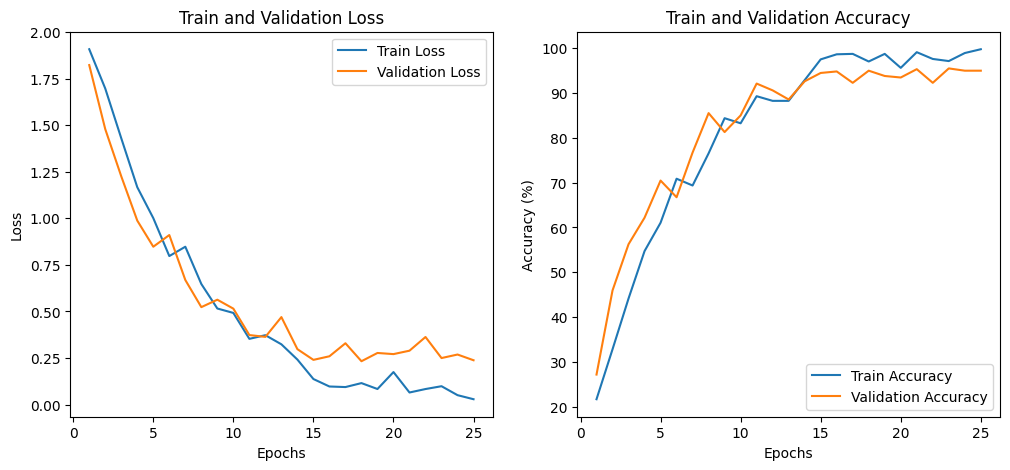

In [14]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.show()